# NLP Project 2: English-Portuguese Machine Translation

# ✅ Task 1: Data Exploration (15%)

### 1.1 Installing Libraries and General Imports

In [1]:
!pip install sacrebleu

# --- Standard Library Imports ---
import json
import os
import re
import shutil
import warnings
from collections import Counter

# --- Third-Party Library Imports ---
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from sacrebleu.metrics import BLEU as SacrebleuBLEU
from scipy import stats
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# --- TensorFlow and Keras Imports ---
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    AdditiveAttention,
    Concatenate,
    Dense,
    Embedding,
    GRU,
    Input,
    LSTM,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# --- Configuration and Setup ---
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.0 MB/s eta 0:00:00


2025-07-24 11:40:49.371757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753357249.573328      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753357249.637787      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


True

### 1.1.2 Loading Pre-trained Embedding Models

In [2]:
glove_file = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

word2vec_file_path = '/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)

embedding_dim_w2v = word2vec_model.vector_size
print(f"Word2Vec embedding dimension: {embedding_dim_w2v}")

Word2Vec embedding dimension: 300


### 1.2 In-Depth Corpus Analysis and Visualization

=== Portuguese-English Europarl Corpus Analysis ===

1. Loading parallel corpus data...
English sentences: 1,960,407
Portuguese sentences: 1,960,407
Files aligned: True

2. Calculating sentence statistics...

English Statistics:
  Mean: 25.15
  Median: 22.00
  Std: 15.20
  Min: 1.00
  Max: 668.00

Portuguese Statistics:
  Mean: 25.51
  Median: 23.00
  Std: 15.65
  Min: 1.00
  Max: 636.00

3. Creating main visualizations...


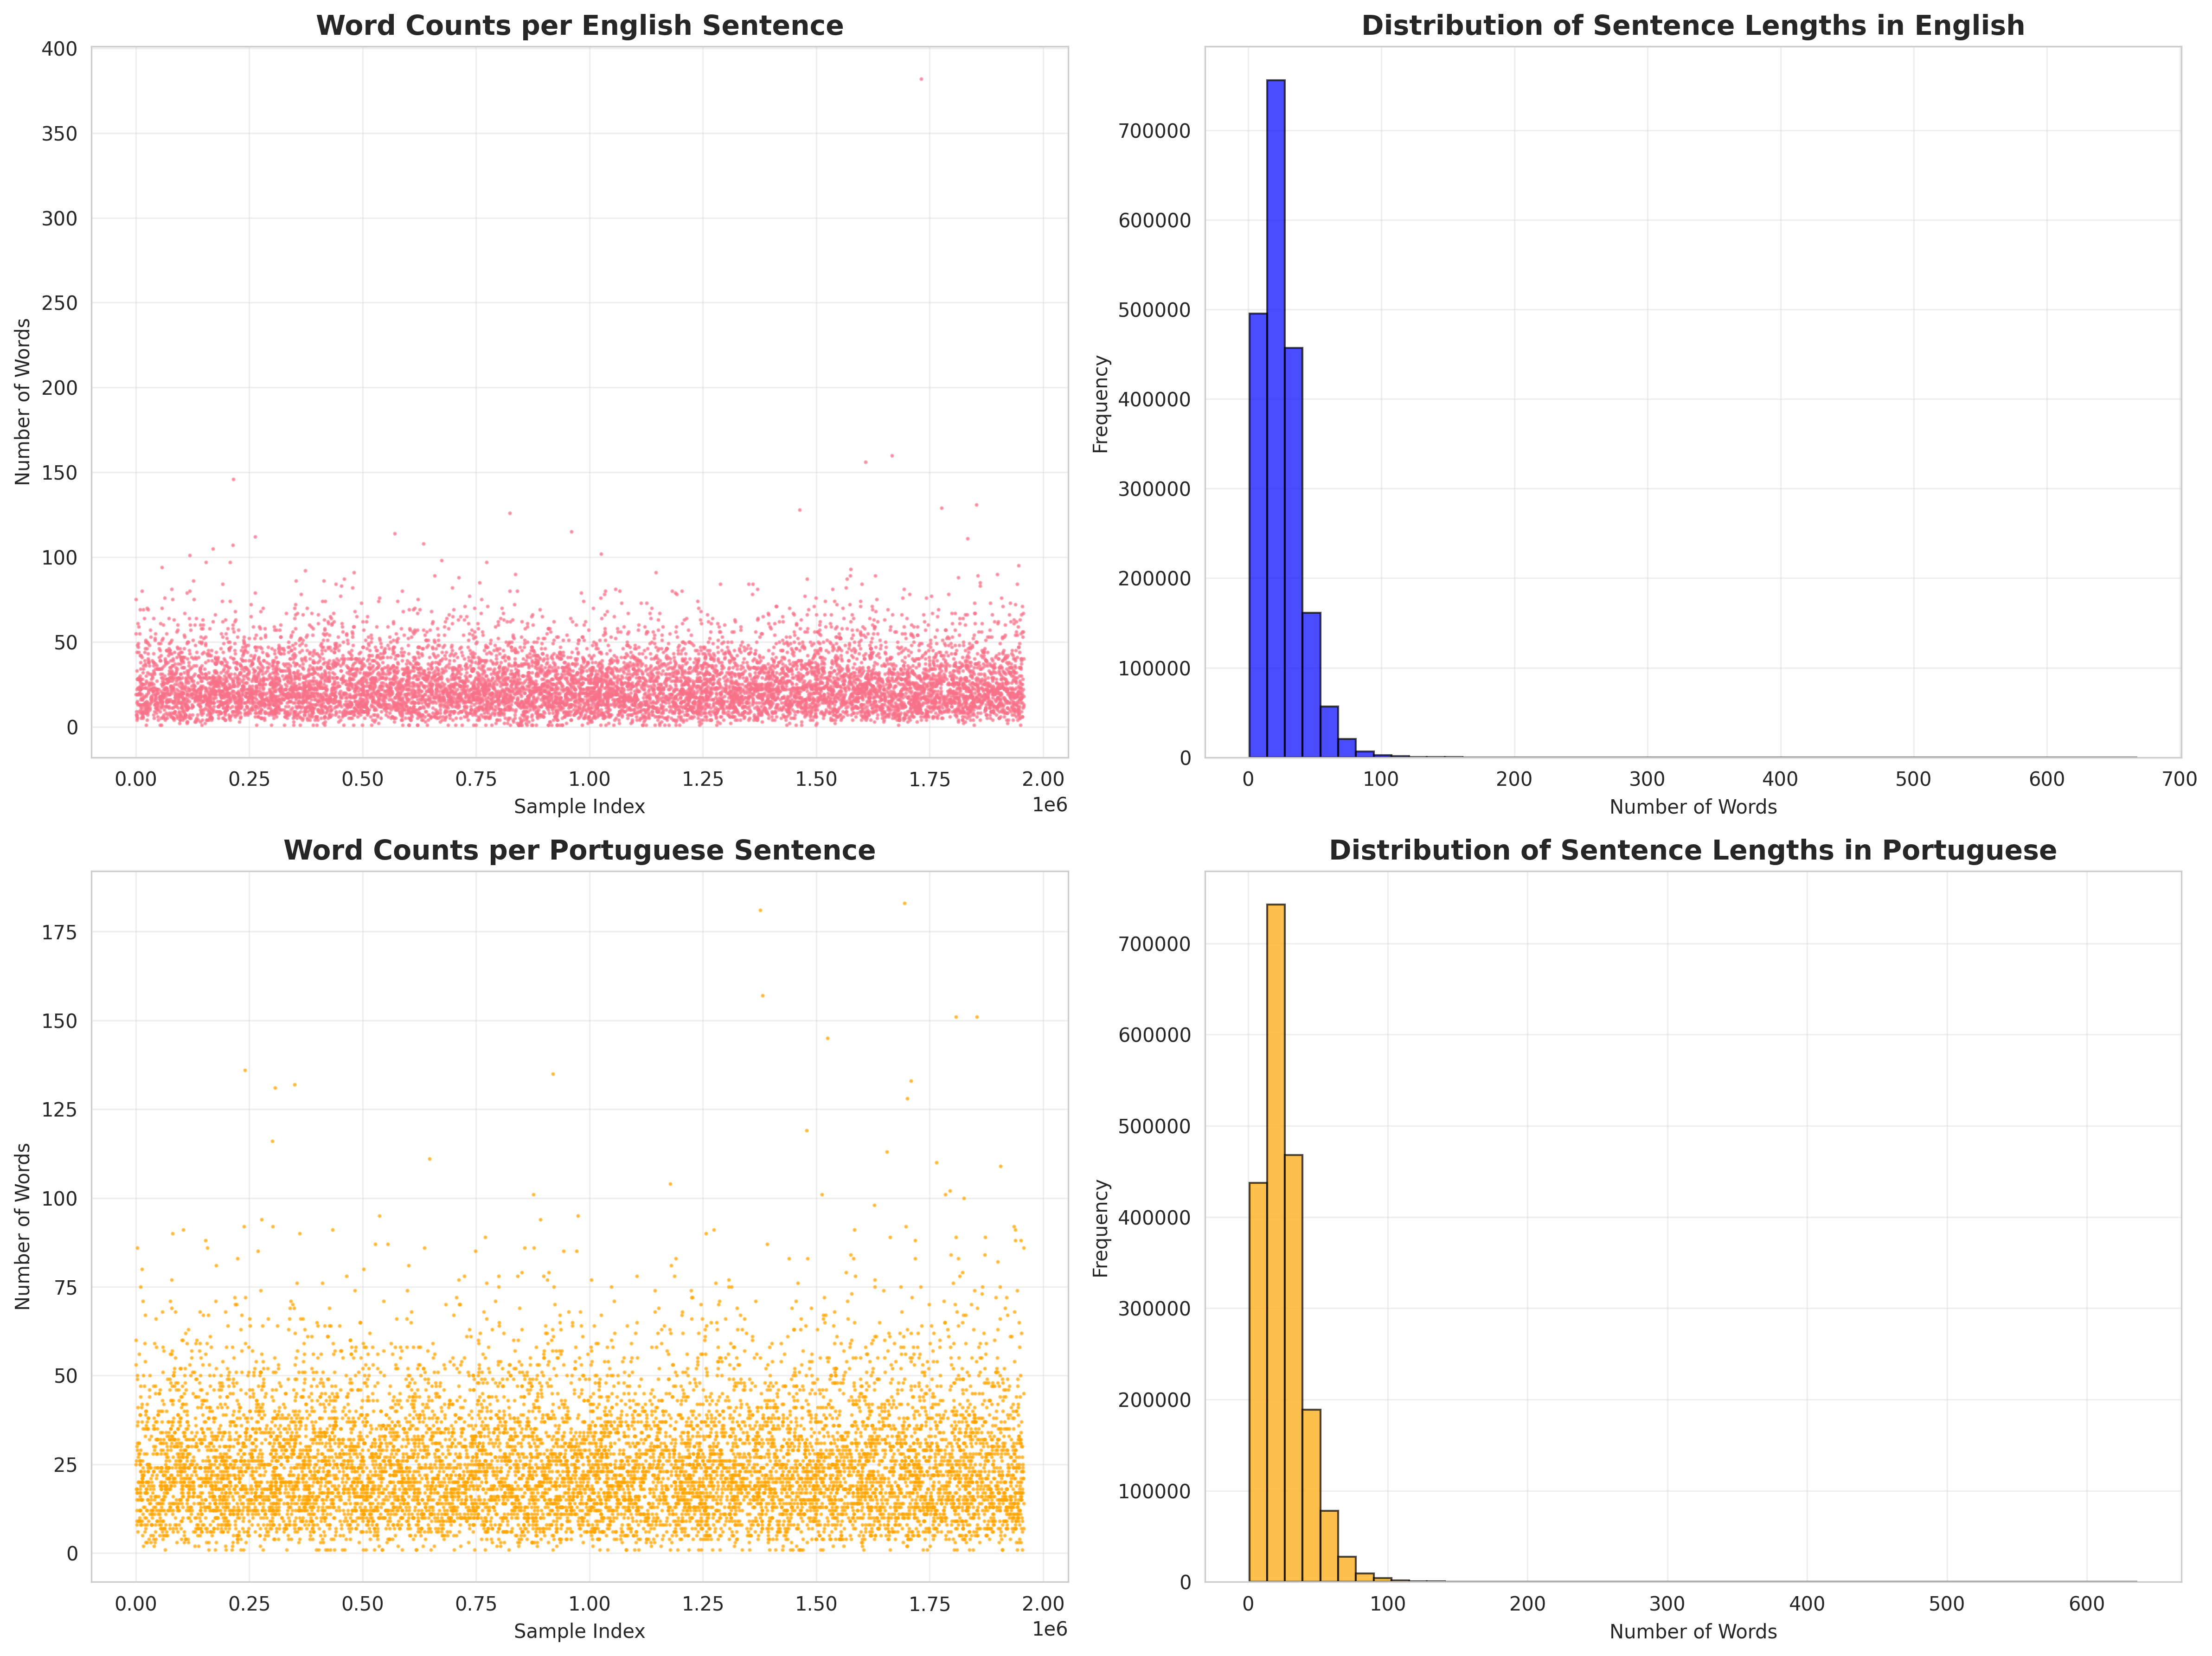


4. Analyzing length differences...


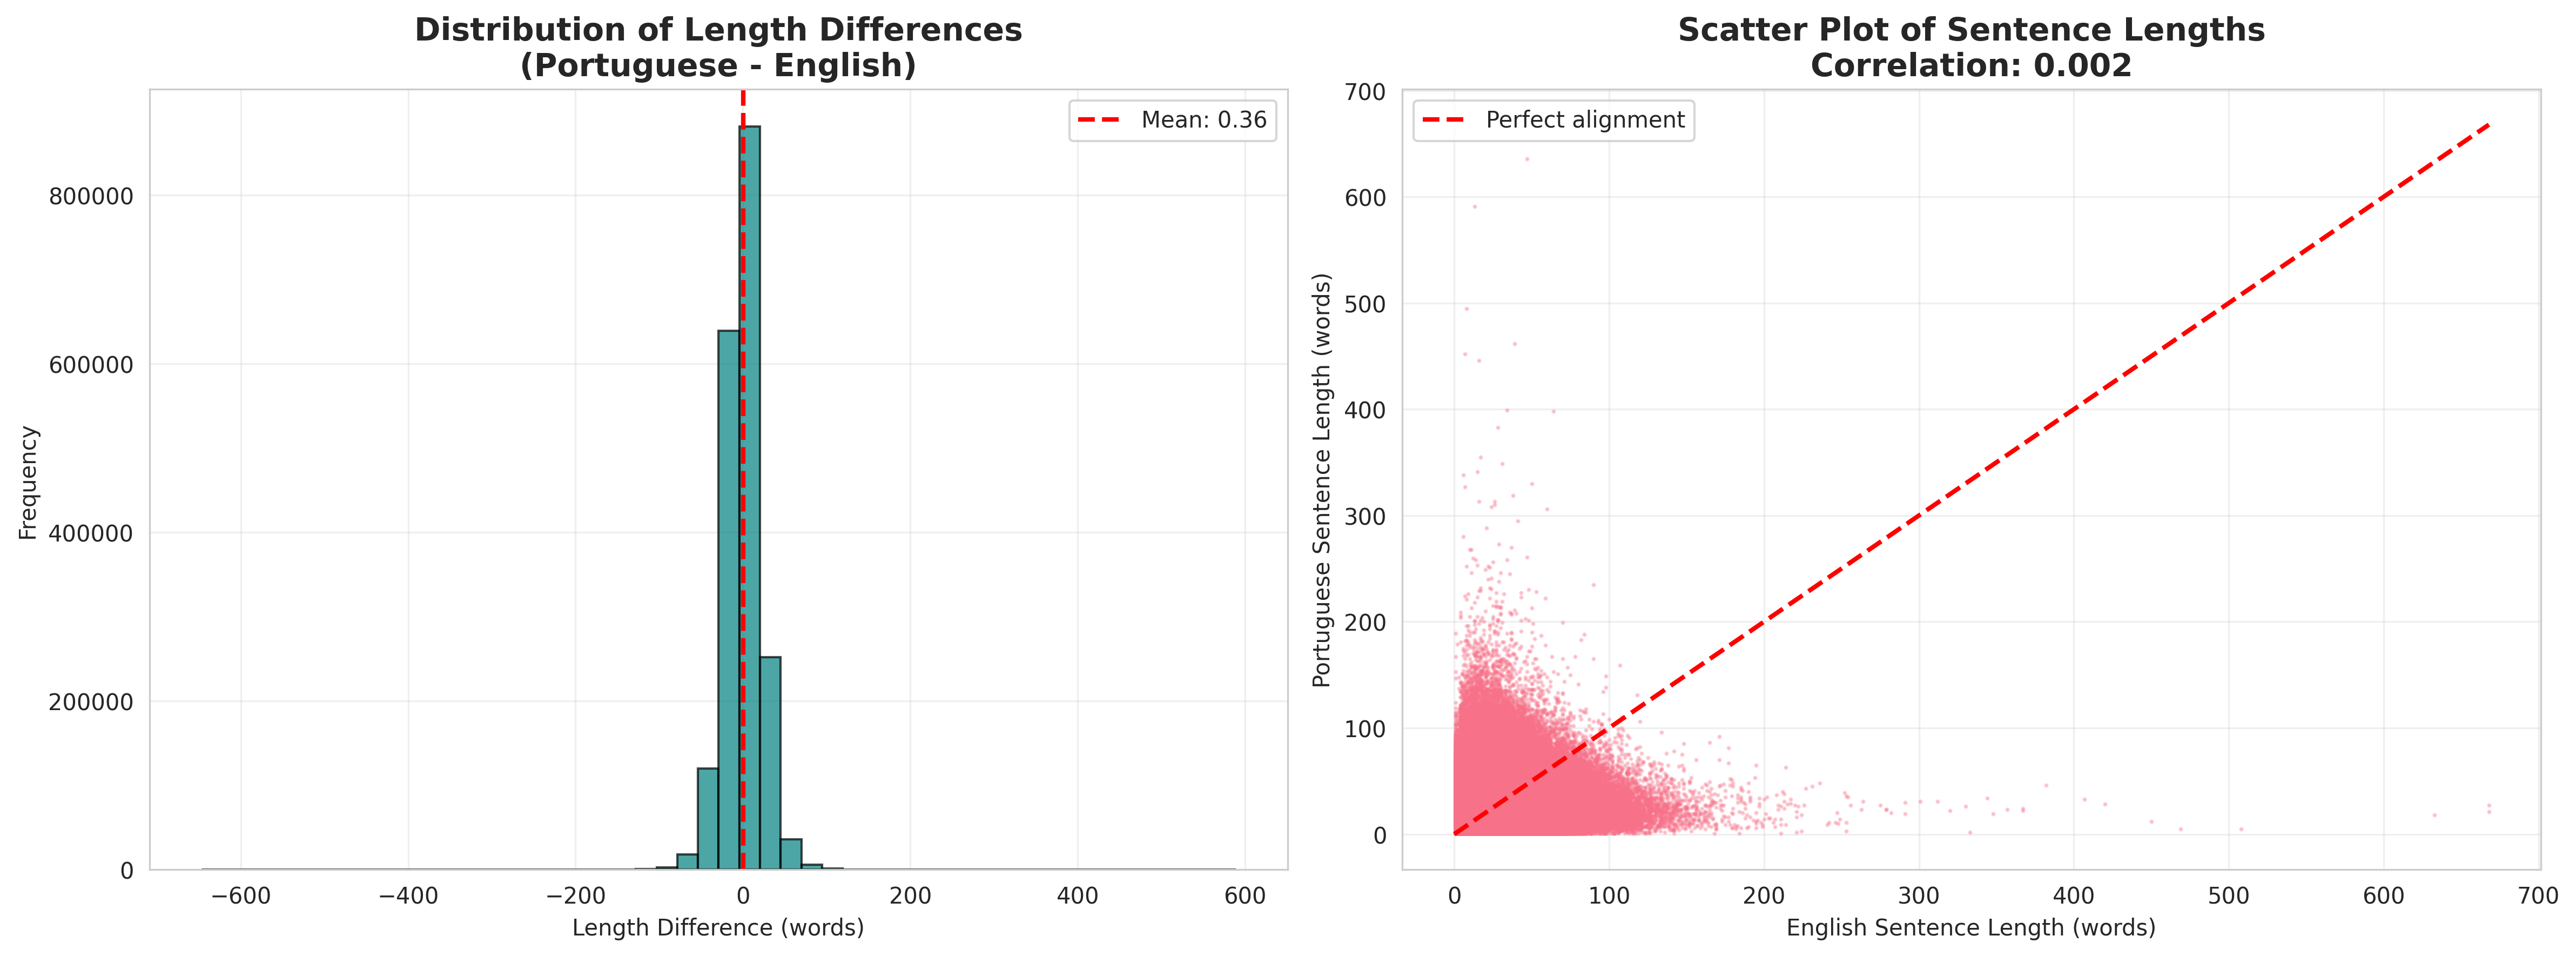


5. Performing additional analyses...
Average characters per sentence - English: 149.6, Portuguese: 160.9
Unique vocabulary - English: 159,704, Portuguese: 210,408


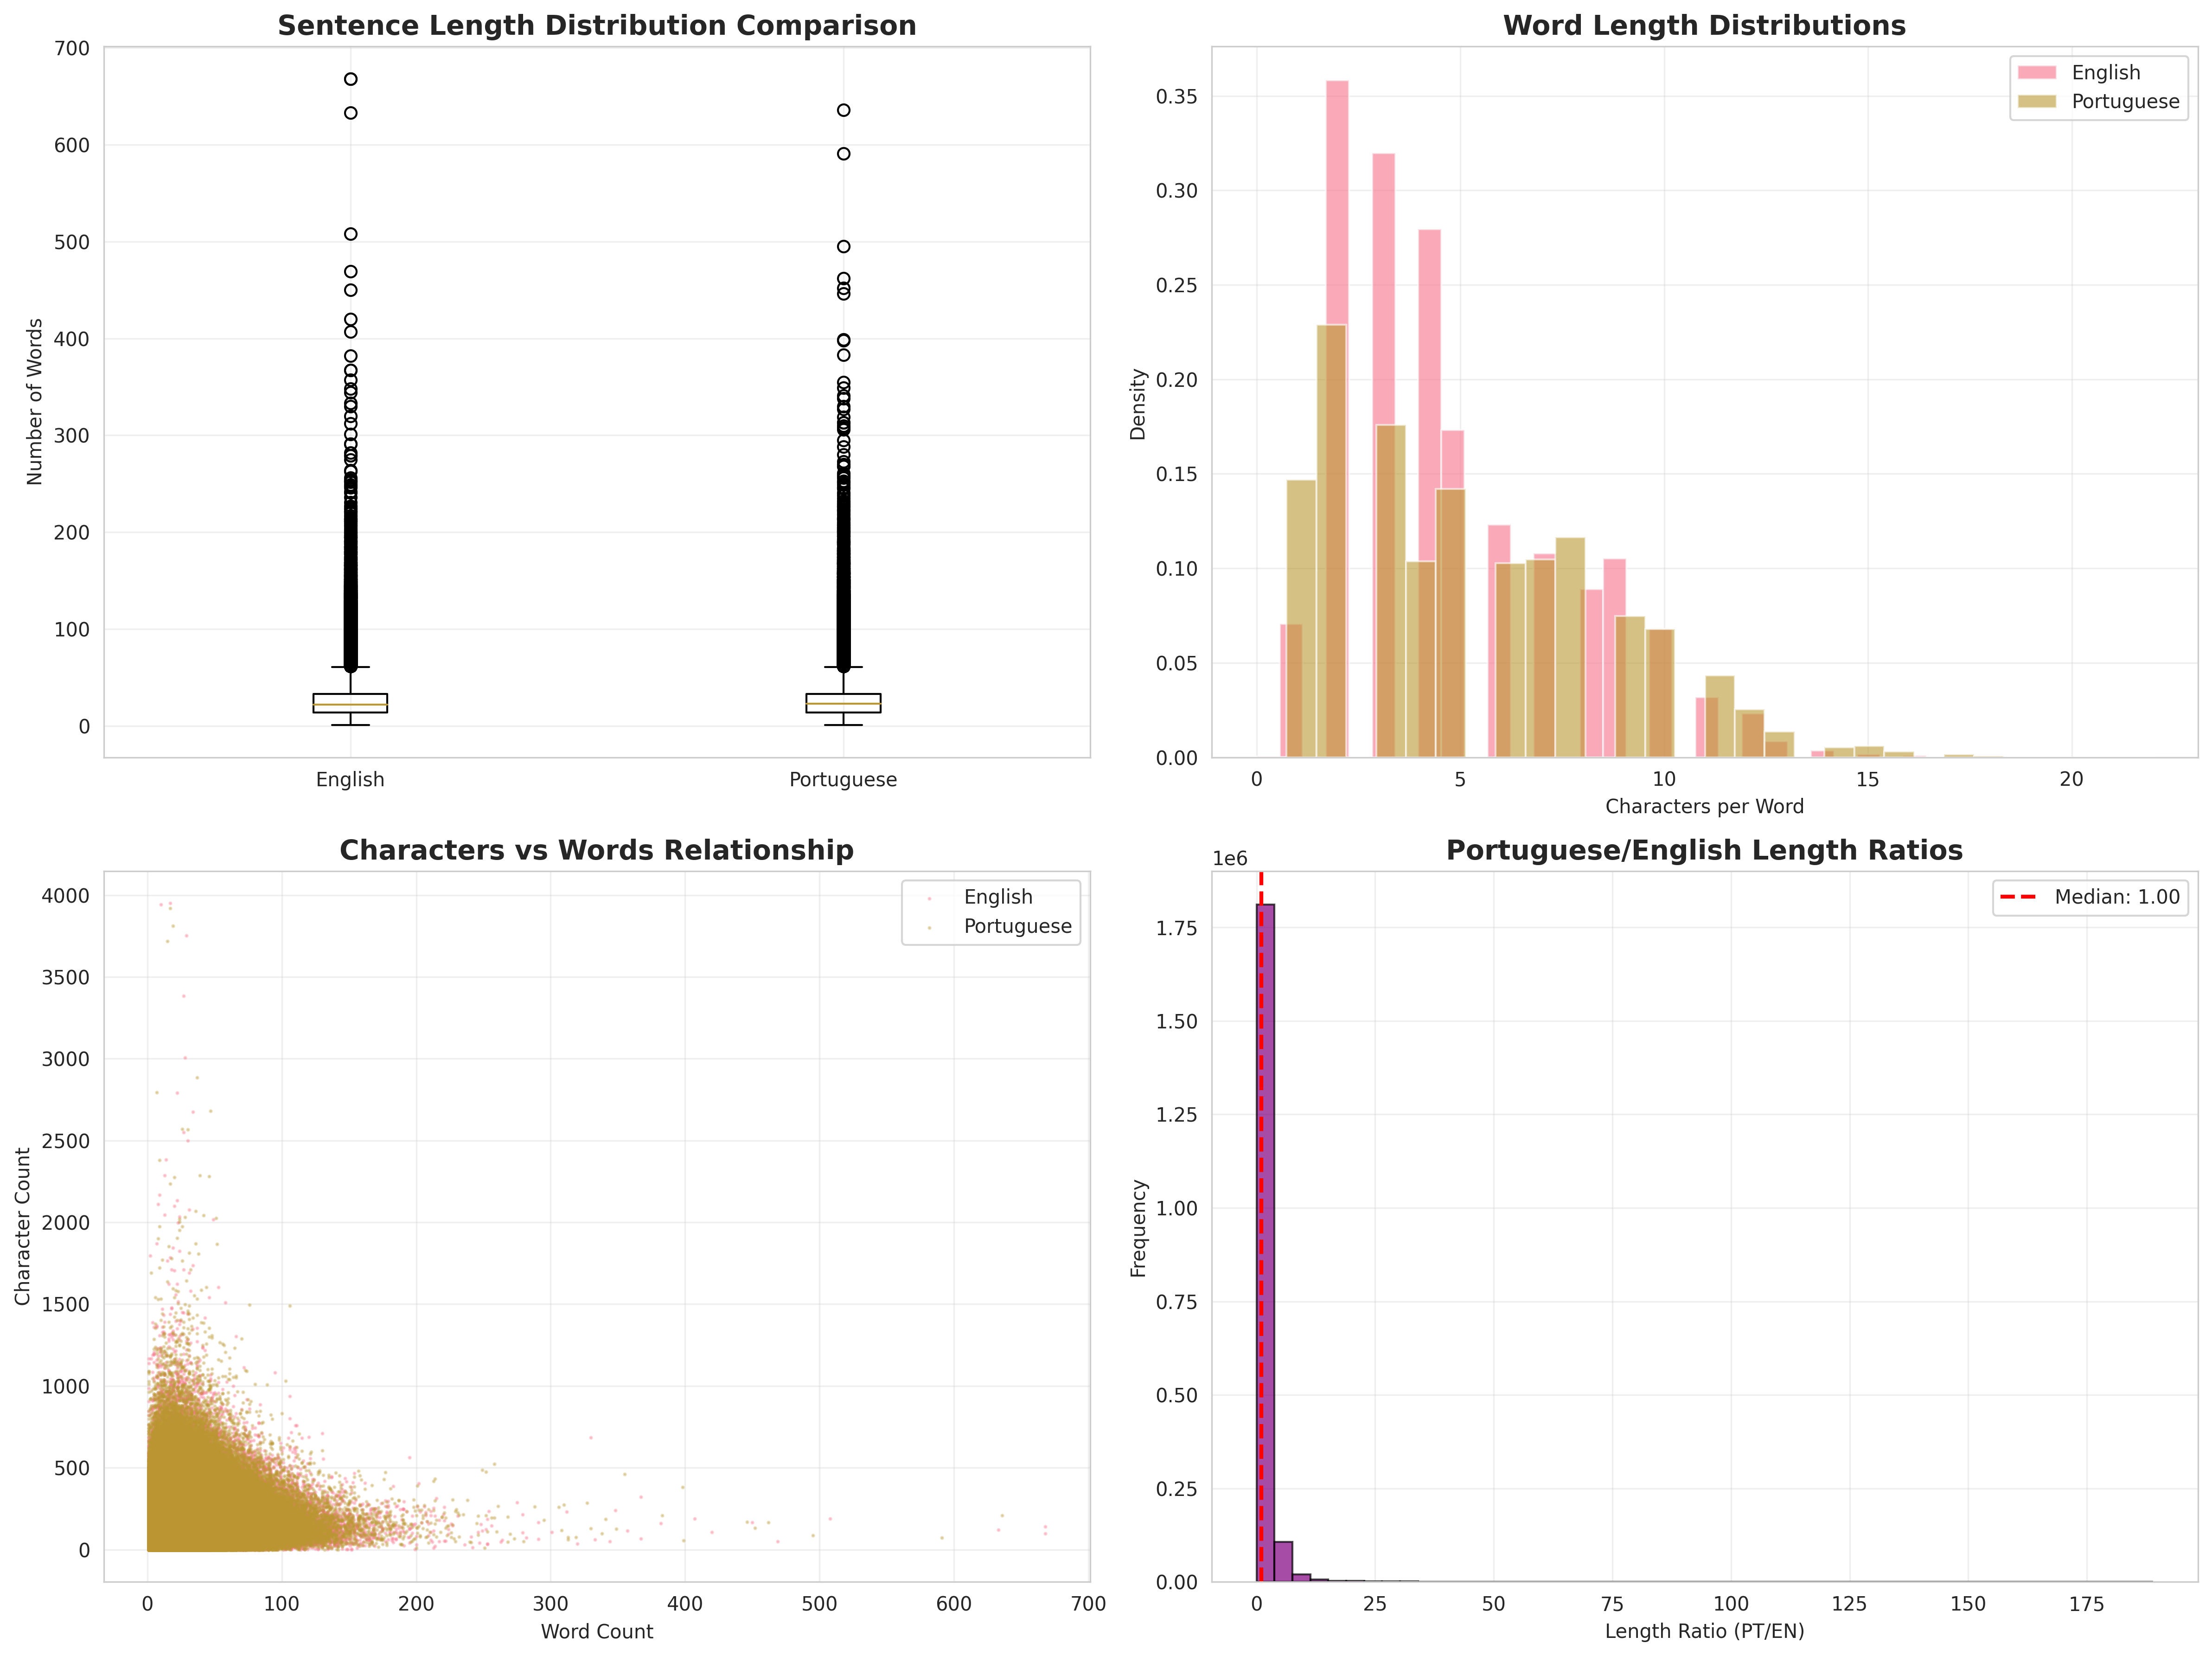


6. Identifying outliers and interesting examples...
Sentences longer than 75 words:
  English: 17240 sentences
  Portuguese: 19312 sentences

Examples of longest sentences:

Longest English sentence (668 words):
'What we need is more resources for the caterer to ensure that none of our family or our guests leaves our educational table unfed or hungry....'

Longest Portuguese sentence (636 words):
'Será que a aplicação de uma tarifa superior à correspondência intracomunitária não nacional do primeiro escalão, por parte dos serviços postais do Reino Unido, constitui uma infracção nos termos do ar...'

Poorly aligned sentence pairs (ratio > 3.0): 431930

Worst alignment example (ratio: 211.00):
English (211 words): 'For about the last two months, drivers working for the European Parliament have been repeatedly stopped and checked by the police, as was the case on ...'
Portuguese (1 words): 'Há dois meses que, durante a semana da sessão plenária, os motoristas do Parlamento vêm sendo cons

In [3]:
# Configure matplotlib for high-quality plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300
sns.set_style("whitegrid")
sns.set_palette("husl")

print("=== Portuguese-English Europarl Corpus Analysis ===\n")

# ==================== DATA LOADING ====================
print("1. Loading parallel corpus data...")

# Load the Portuguese-English parallel files
en_file_path = "/kaggle/input/europarl-datasets/europarl-v7.pt-en.en"
pt_file_path = "/kaggle/input/europarl-datasets/europarl-v7.pt-en.pt"

# Read files with proper encoding
with open(en_file_path, 'r', encoding='utf-8') as f:
    english_sentences = [line.strip() for line in f.readlines()]

with open(pt_file_path, 'r', encoding='utf-8') as f:
    portuguese_sentences = [line.strip() for line in f.readlines()]

# Basic corpus statistics
total_en_sentences = len(english_sentences)
total_pt_sentences = len(portuguese_sentences)

print(f"English sentences: {total_en_sentences:,}")
print(f"Portuguese sentences: {total_pt_sentences:,}")
print(f"Files aligned: {total_en_sentences == total_pt_sentences}")

# ==================== PREPROCESSING & STATISTICS ====================
print("\n2. Calculating sentence statistics...")

# Calculate word counts for each sentence
en_word_counts = [len(sent.split()) for sent in english_sentences if sent.strip()]
pt_word_counts = [len(sent.split()) for sent in portuguese_sentences if sent.strip()]

# Ensure equal lengths for paired analysis
min_length = min(len(en_word_counts), len(pt_word_counts))
en_word_counts = en_word_counts[:min_length]
pt_word_counts = pt_word_counts[:min_length]

# Basic statistics
en_stats = {
    'mean': np.mean(en_word_counts),
    'median': np.median(en_word_counts),
    'std': np.std(en_word_counts),
    'min': np.min(en_word_counts),
    'max': np.max(en_word_counts)
}

pt_stats = {
    'mean': np.mean(pt_word_counts),
    'median': np.median(pt_word_counts),
    'std': np.std(pt_word_counts),
    'min': np.min(pt_word_counts),
    'max': np.max(pt_word_counts)
}

print(f"\nEnglish Statistics:")
for key, value in en_stats.items():
    print(f"  {key.capitalize()}: {value:.2f}")

print(f"\nPortuguese Statistics:")
for key, value in pt_stats.items():
    print(f"  {key.capitalize()}: {value:.2f}")

# ==================== MAIN VISUALIZATIONS ====================
print("\n3. Creating main visualizations...")

# Figure 1: Sentence Length Distributions (replicating the Dutch-English analysis)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# English word counts per sentence (top left)
sample_indices = np.random.choice(len(en_word_counts), size=min(10000, len(en_word_counts)), replace=False)
ax1.scatter(sample_indices, [en_word_counts[i] for i in sample_indices], alpha=0.6, s=1)
ax1.set_title('Word Counts per English Sentence', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number of Words')
ax1.grid(True, alpha=0.3)

# English sentence length distribution (top right)
ax2.hist(en_word_counts, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax2.set_title('Distribution of Sentence Lengths in English', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# Portuguese word counts per sentence (bottom left)
ax3.scatter(sample_indices, [pt_word_counts[i] for i in sample_indices], alpha=0.6, s=1, color='orange')
ax3.set_title('Word Counts per Portuguese Sentence', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Number of Words')
ax3.grid(True, alpha=0.3)

# Portuguese sentence length distribution (bottom right)
ax4.hist(pt_word_counts, bins=50, alpha=0.7, color='orange', edgecolor='black')
ax4.set_title('Distribution of Sentence Lengths in Portuguese', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Words')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('portuguese_english_sentence_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Length Differences Analysis
print("\n4. Analyzing length differences...")

# Calculate length differences (Portuguese - English)
length_differences = [pt - en for pt, en in zip(pt_word_counts, en_word_counts)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Length differences histogram
ax1.hist(length_differences, bins=50, alpha=0.7, color='teal', edgecolor='black')
ax1.axvline(np.mean(length_differences), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(length_differences):.2f}')
ax1.set_title('Distribution of Length Differences\n(Portuguese - English)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Length Difference (words)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot of Portuguese vs English lengths
ax2.scatter(en_word_counts, pt_word_counts, alpha=0.3, s=1)
ax2.plot([0, max(max(en_word_counts), max(pt_word_counts))],
         [0, max(max(en_word_counts), max(pt_word_counts))],
         'r--', linewidth=2, label='Perfect alignment')
correlation = np.corrcoef(en_word_counts, pt_word_counts)[0, 1]
ax2.set_title(f'Scatter Plot of Sentence Lengths\nCorrelation: {correlation:.3f}', fontsize=14, fontweight='bold')
ax2.set_xlabel('English Sentence Length (words)')
ax2.set_ylabel('Portuguese Sentence Length (words)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('length_differences_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== ADDITIONAL INTERESTING ANALYSES ====================
print("\n5. Performing additional analyses...")

# Analysis 1: Character-level statistics
en_char_counts = [len(sent) for sent in english_sentences[:min_length]]
pt_char_counts = [len(sent) for sent in portuguese_sentences[:min_length]]

print(f"Average characters per sentence - English: {np.mean(en_char_counts):.1f}, Portuguese: {np.mean(pt_char_counts):.1f}")

# Analysis 2: Word length analysis
en_word_lengths = []
pt_word_lengths = []

for sent in english_sentences[:min_length]:
    words = sent.split()
    en_word_lengths.extend([len(word.strip('.,!?;:"()[]')) for word in words if word.strip()])

for sent in portuguese_sentences[:min_length]:
    words = sent.split()
    pt_word_lengths.extend([len(word.strip('.,!?;:"()[]')) for word in words if word.strip()])

# Analysis 3: Vocabulary richness
en_vocabulary = set()
pt_vocabulary = set()

for sent in english_sentences[:min_length]:
    en_vocabulary.update(word.lower().strip('.,!?;:"()[]') for word in sent.split() if word.strip())

for sent in portuguese_sentences[:min_length]:
    pt_vocabulary.update(word.lower().strip('.,!?;:"()[]') for word in sent.split() if word.strip())

print(f"Unique vocabulary - English: {len(en_vocabulary):,}, Portuguese: {len(pt_vocabulary):,}")

# Figure 3: Advanced Comparative Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Box plot comparison
data_for_box = [en_word_counts, pt_word_counts]
ax1.boxplot(data_for_box, labels=['English', 'Portuguese'])
ax1.set_title('Sentence Length Distribution Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Words')
ax1.grid(True, alpha=0.3)

# Word length distributions
ax2.hist(en_word_lengths[:10000], bins=30, alpha=0.6, label='English', density=True)
ax2.hist(pt_word_lengths[:10000], bins=30, alpha=0.6, label='Portuguese', density=True)
ax2.set_title('Word Length Distributions', fontsize=14, fontweight='bold')
ax2.set_xlabel('Characters per Word')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Characters vs Words correlation
ax3.scatter(en_word_counts, en_char_counts, alpha=0.3, s=1, label='English')
ax3.scatter(pt_word_counts, pt_char_counts, alpha=0.3, s=1, label='Portuguese')
ax3.set_title('Characters vs Words Relationship', fontsize=14, fontweight='bold')
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Character Count')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Length ratio analysis
length_ratios = [pt/en if en > 0 else 0 for pt, en in zip(pt_word_counts, en_word_counts)]
ax4.hist(length_ratios, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax4.axvline(np.median(length_ratios), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(length_ratios):.2f}')
ax4.set_title('Portuguese/English Length Ratios', fontsize=14, fontweight='bold')
ax4.set_xlabel('Length Ratio (PT/EN)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('advanced_comparative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== OUTLIER DETECTION & EXAMPLES ====================
print("\n6. Identifying outliers and interesting examples...")

# Find outliers
outlier_threshold = np.percentile(en_word_counts + pt_word_counts, 99)
en_outliers = [(i, count) for i, count in enumerate(en_word_counts) if count > outlier_threshold]
pt_outliers = [(i, count) for i, count in enumerate(pt_word_counts) if count > outlier_threshold]

print(f"Sentences longer than {outlier_threshold:.0f} words:")
print(f"  English: {len(en_outliers)} sentences")
print(f"  Portuguese: {len(pt_outliers)} sentences")

# Show examples of longest sentences
print("\nExamples of longest sentences:")
en_longest_idx = np.argmax(en_word_counts)
pt_longest_idx = np.argmax(pt_word_counts)

print(f"\nLongest English sentence ({en_word_counts[en_longest_idx]} words):")
print(f"'{english_sentences[en_longest_idx][:200]}...'")

print(f"\nLongest Portuguese sentence ({pt_word_counts[pt_longest_idx]} words):")
print(f"'{portuguese_sentences[pt_longest_idx][:200]}...'")

# Find poorly aligned sentence pairs
alignment_threshold = 3.0
poorly_aligned = []

for i, (en_len, pt_len) in enumerate(zip(en_word_counts, pt_word_counts)):
    if en_len > 0 and pt_len > 0:
        ratio = max(en_len, pt_len) / min(en_len, pt_len)
        if ratio > alignment_threshold:
            poorly_aligned.append((i, en_len, pt_len, ratio))

print(f"\nPoorly aligned sentence pairs (ratio > {alignment_threshold}): {len(poorly_aligned)}")

if poorly_aligned:
    worst_alignment = max(poorly_aligned, key=lambda x: x[3])
    idx, en_len, pt_len, ratio = worst_alignment
    print(f"\nWorst alignment example (ratio: {ratio:.2f}):")
    print(f"English ({en_len} words): '{english_sentences[idx][:150]}...'")
    print(f"Portuguese ({pt_len} words): '{portuguese_sentences[idx][:150]}...'")

# ==================== SUMMARY REPORT ====================
print("\n" + "="*60)
print("CORPUS ANALYSIS SUMMARY")
print("="*60)

summary_stats = {
    'Total sentence pairs': min_length,
    'Avg words per sentence (EN)': f"{np.mean(en_word_counts):.2f}",
    'Avg words per sentence (PT)': f"{np.mean(pt_word_counts):.2f}",
    'Length correlation': f"{correlation:.3f}",
    'Unique English words': f"{len(en_vocabulary):,}",
    'Unique Portuguese words': f"{len(pt_vocabulary):,}",
    'Poorly aligned pairs': f"{len(poorly_aligned)} ({len(poorly_aligned)/min_length*100:.2f}%)",
    'Outlier sentences': f"{len(en_outliers) + len(pt_outliers)}"
}

for key, value in summary_stats.items():
    print(f"{key:.<30} {value}")

print(f"\nKey Finding: Portuguese sentences are on average {np.mean(pt_word_counts) - np.mean(en_word_counts):.2f} words {'longer' if np.mean(pt_word_counts) > np.mean(en_word_counts) else 'shorter'} than English sentences.")

# ✅ Task 2: Preprocessing (10%)

### 2.1 Defining the Preprocessing Function

In [4]:
def preprocess_text(text):
    """
    Preprocess a given text string by cleaning, lowercasing, and tokenizing.
    """
    # Remove leading and trailing whitespace
    text = text.strip()
    # Skip empty strings or lines starting with '<' (e.g., XML/HTML tags)
    if text == '' or text.startswith('<'):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Replace multiple whitespace with a single space and trim again
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize the text using NLTK
    tokens = nltk.word_tokenize(text)
    # Join tokens back into a single string separated by spaces
    return " ".join(tokens)

### 2.2 Applying Preprocessing and Creating the Final DataFrame

In [5]:
# Create DataFrames for English and Portuguese sentences
english_sentences_df = pd.DataFrame(english_sentences, columns=['en_sentence'])
portuguese_sentences_df = pd.DataFrame(portuguese_sentences, columns=['pt_sentence'])
df = pd.concat([english_sentences_df, portuguese_sentences_df], axis=1)

# Define the path for the preprocessed data file
parquet_file_path = '/kaggle/input/preprocessed-accurate/preprocessed_accurate.parquet'

# Check if the preprocessed file already exists
if os.path.exists(parquet_file_path):
    print(f"Loading preprocessed data from '{parquet_file_path}'...")
    df = pd.read_parquet(parquet_file_path)

else:
    print(f"File '{parquet_file_path}' not found. Performing preprocessing...")

    # Step 1: Apply preprocessing to all data
    print("Step 1: Applying preprocessing...")
    for col in ['en_sentence', 'pt_sentence']:
        df[col] = df[col].apply(lambda x: preprocess_text(x))

    # Step 2: Remove empty rows resulting from preprocessing
    df = df[(df['en_sentence'] != '') & (df['pt_sentence'] != '')].copy()

    # Step 3: Filter sentences by maximum token length
    print("Step 2: Filtering by maximum token length...")
    max_sentence_length = 100
    df['en_len'] = df['en_sentence'].str.split().str.len()
    df['pt_len'] = df['pt_sentence'].str.split().str.len()
    df = df[(df['en_len'] <= max_sentence_length) & (df['pt_len'] <= max_sentence_length)]
    df = df.drop(columns=['en_len', 'pt_len'])

    # Step 4: Take a random sample of the filtered data
    print("Step 3: Taking a random sample...")
    df = df.sample(frac=0.1, random_state=42)

    # Step 5: Reset index and save the final DataFrame
    df = df.reset_index(drop=True)
    print(f"Saving preprocessed data to '{parquet_file_path}' for future use.")
    df.to_parquet(parquet_file_path, index=False)

# Display the final result
print("\n--- Result ---")
print(df.tail())

Loading preprocessed data from '/kaggle/input/preprocessed-accurate/preprocessed_accurate.parquet'...

--- Result ---
                                             en_sentence  \
97409  i think it is the right way forward to say tha...   
97410  in particular , the report looks at mutual hea...   
97411  for example , in france , there have been prob...   
97412  we are prepared to give special attention to t...   
97413  the slovene authorities have accepted this cri...   

                                             pt_sentence  
97409  penso ser correcto afirmar que o serviço de ac...  
97410  este relatório debruça-se , em particular , so...  
97411  em frança , por exemplo , houve problemas de f...  
97412  estamos preparados para conceder especial aten...  
97413  as autoridades eslovenas aceitaram este juízo ...  


# ✅ Task 3: Neural Machine Translation (60%)

## 3.1 Base Model


### 3.1.1 Splitting the data into Train-/Test-/Validationdata

In [6]:
# Add special start and end tokens to each sentence if not already present
if not df['en_sentence'].str.startswith('<sos>').all():
    df['en_sentence'] = df['en_sentence'].apply(lambda sentence: '<sos> ' + str(sentence) + ' <eos>')

if not df['pt_sentence'].str.startswith('<sos>').all():
    df['pt_sentence'] = df['pt_sentence'].apply(lambda sentence: '<sos> ' + str(sentence) + ' <eos>')

# Split the data: first, set aside 20% for the test set
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the remaining 80% into training and validation sets (10% of remaining for validation)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

# Print the sizes of each dataset to verify the split
print(f"Total samples: {len(df)}")
print("-" * 20)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total samples: 97414
--------------------
Training set size: 70137
Validation set size: 7794
Test set size: 19483


### 3.1.2 Creating a vocabulary and convert sentences into number lists

In [7]:
# We use the DataFrames train_df, val_df, and test_df from the previous step.

# Set the number of most frequent words to use in the vocabulary
num_most_frequent_words = 20000

# Create English tokenizer, fit only on training data to avoid data leakage
# filters='' ensures that special tokens like <sos> and <eos> are not removed
en_tokenizer = Tokenizer(filters='', num_words=num_most_frequent_words, oov_token="<unk>")
en_tokenizer.fit_on_texts(train_df['en_sentence'])

# Create Portuguese tokenizer, fit only on training data
pt_tokenizer = Tokenizer(filters='', num_words=num_most_frequent_words, oov_token="<unk>")
pt_tokenizer.fit_on_texts(train_df['pt_sentence'])

# Store vocabulary sizes for later use (important for embedding layers)
# Add +1 because index 0 is reserved for padding
en_vocab_size = len(en_tokenizer.word_index) + 1
pt_vocab_size = len(pt_tokenizer.word_index) + 1

print(f"English vocabulary size: {en_vocab_size} words")
print(f"Portuguese vocabulary size: {pt_vocab_size} words")
print("-" * 20)

# Convert all sentences to sequences of integers
# Training data
train_en_seq = en_tokenizer.texts_to_sequences(train_df['en_sentence'])
train_pt_seq = pt_tokenizer.texts_to_sequences(train_df['pt_sentence'])

# Validation data
val_en_seq = en_tokenizer.texts_to_sequences(val_df['en_sentence'])
val_pt_seq = pt_tokenizer.texts_to_sequences(val_df['pt_sentence'])

# Test data
test_en_seq = en_tokenizer.texts_to_sequences(test_df['en_sentence'])
test_pt_seq = pt_tokenizer.texts_to_sequences(test_df['pt_sentence'])

# Create reverse mappings (index -> word) for later translation
reverse_en_word_index = {v: k for k, v in en_tokenizer.word_index.items()}
reverse_pt_word_index = {v: k for k, v in pt_tokenizer.word_index.items()}

# Example output to show the result
print("Original English sentence:")
print(train_df['en_sentence'].iloc[0])
print("\nAfter converting to a sequence of integers:")
print(train_en_seq[0])

English vocabulary size: 30995 words
Portuguese vocabulary size: 46430 words
--------------------
Original English sentence:
<sos> however , the commission 's negative decision regarding the shipyards will now result in their bankruptcy , and this situation is difficult to accept . <eos>

After converting to a sequence of integers:
[4, 100, 3, 2, 34, 51, 1200, 306, 533, 2, 5086, 28, 91, 316, 10, 60, 5662, 3, 9, 17, 147, 12, 361, 8, 481, 6, 5]


### 3.1.3 Padding

In [8]:
# Use the tokenized data (e.g., train_en_seq) from the previous step

# 1. Determine the maximum sequence length from the training data to avoid data leakage
max_en_len = max(len(s) for s in train_en_seq)
max_pt_len = max(len(s) for s in train_pt_seq)

print(f"Maximum length of English sentences: {max_en_len}")
print(f"Maximum length of Portuguese sentences: {max_pt_len}")
print("-" * 20)

# 2. Apply padding to all datasets
# 'padding="post"' means zeros are added at the end of the sequence
train_en_padded = pad_sequences(train_en_seq, maxlen=max_en_len, padding='post')
val_en_padded = pad_sequences(val_en_seq, maxlen=max_en_len, padding='post')
test_en_padded = pad_sequences(test_en_seq, maxlen=max_en_len, padding='post')

train_pt_padded = pad_sequences(train_pt_seq, maxlen=max_pt_len, padding='post')
val_pt_padded = pad_sequences(val_pt_seq, maxlen=max_pt_len, padding='post')
test_pt_padded = pad_sequences(test_pt_seq, maxlen=max_pt_len, padding='post')

# Example output to show the result
print("An original sequence before padding:")
print(train_en_seq[0])
print(f"Length: {len(train_en_seq[0])}\n")

print("The same sequence after padding:")
print(train_en_padded[0])
print(f"Length: {len(train_en_padded[0])}")

Maximum length of English sentences: 102
Maximum length of Portuguese sentences: 102
--------------------
An original sequence before padding:
[4, 100, 3, 2, 34, 51, 1200, 306, 533, 2, 5086, 28, 91, 316, 10, 60, 5662, 3, 9, 17, 147, 12, 361, 8, 481, 6, 5]
Length: 27

The same sequence after padding:
[   4  100    3    2   34   51 1200  306  533    2 5086   28   91  316
   10   60 5662    3    9   17  147   12  361    8  481    6    5    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Length: 102


### 3.1.4 Base Model Architecture

In [9]:
# Clear the current Keras session to start from scratch
K.clear_session()

# Set hyperparameters for the base model
embedding_dim_base = 256
latent_dim_base = 256

# Encoder definition
encoder_inputs_base = Input(shape=(max_en_len,), name='encoder_inputs_base')

# Encoder embedding layer
enc_emb_layer_base = Embedding(num_most_frequent_words, embedding_dim_base, name='encoder_embedding_base')
enc_emb_base = enc_emb_layer_base(encoder_inputs_base)

# Encoder LSTM layer (recurrent_dropout is set to 0 for GPU compatibility)
encoder_lstm_base = LSTM(latent_dim_base, return_state=True, name='encoder_lstm_base')
_, state_h_base, state_c_base = encoder_lstm_base(enc_emb_base)

# Store encoder states to pass to the decoder
encoder_states_base = [state_h_base, state_c_base]

# Decoder definition
decoder_inputs_base = Input(shape=(max_pt_len,), name='decoder_inputs_base')

# Decoder embedding layer (separate from encoder embedding)
dec_emb_layer_base = Embedding(num_most_frequent_words, embedding_dim_base, name='decoder_embedding_base')
dec_emb_base = dec_emb_layer_base(decoder_inputs_base)

# Decoder LSTM layer, initialized with encoder states
decoder_lstm_base = LSTM(latent_dim_base, return_sequences=True, return_state=True, name='decoder_lstm_base')
decoder_outputs_lstm_base, _, _ = decoder_lstm_base(dec_emb_base, initial_state=encoder_states_base)

# Dense output layer with softmax activation for word prediction
decoder_dense_base = Dense(num_most_frequent_words, activation='softmax', name='output_dense_base')
decoder_outputs_base = decoder_dense_base(decoder_outputs_lstm_base)

# Define the full model with encoder and decoder
model_base = Model([encoder_inputs_base, decoder_inputs_base], decoder_outputs_base, name='base_model')

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model_base.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print("--- Base Model Architecture ---")
model_base.summary()

I0000 00:00:1753357539.851745      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


--- Base Model Architecture ---


Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_base │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_base │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 102, 256)  │  5,120,000 │ encoder_inputs_b… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 102, 256)  │  5,120,000 │ decoder_inputs_b… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_base   │ [(None, 256),     │    525,312 │ encoder_embeddin… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_base   │ [(None, 102,      │    525,312 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_bas… │
│                     │ 256), (None,      │            │ encoder_lstm_bas… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_base   │ (None, 102,       │  5,140,000 │ decoder_lstm_bas… │
│ (Dense)             │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,430,624 (62.68 MB)

 Trainable params: 16,430,624 (62.68 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1.5 Training the Base Model

In [10]:
# Prepare decoder input data for training
decoder_input_data = train_pt_padded

# Create decoder target data by shifting the input sequence by one timestep
decoder_target_data = np.zeros_like(train_pt_padded)
decoder_target_data[:, :-1] = train_pt_padded[:, 1:]

# Prepare decoder input and target data for validation set
val_decoder_input_data = val_pt_padded
val_decoder_target_data = np.zeros_like(val_pt_padded)
val_decoder_target_data[:, :-1] = val_pt_padded[:, 1:]

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (train_en_padded, decoder_input_data),  # Tuple of encoder and decoder inputs
        decoder_target_data                     # Decoder targets
    )
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        (val_en_padded, val_decoder_input_data),  # Tuple of encoder and decoder inputs for validation
        val_decoder_target_data                   # Decoder targets for validation
    )
)

# Optimize datasets with shuffling, batching, and prefetching
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train the model or load existing weights if available
base_model_weights_path = '/kaggle/working/base_model_weights.weights.h5'
base_model_weights_kaggle_path = '/kaggle/input/weights/base_model_weights.weights.h5'

if os.path.exists(base_model_weights_path):
    print(f"Loading existing weights for the base model from '{base_model_weights_path}'...")
    model_base.load_weights(base_model_weights_path)
elif os.path.exists(base_model_weights_kaggle_path):
    print(f"Loading existing weights for the base model from '{base_model_weights_kaggle_path}'...")
    model_base.load_weights(base_model_weights_kaggle_path)
else:
    print("--- Starting training of the base model ---\n")
    history_base = model_base.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset
    )
    model_base.save_weights(base_model_weights_path)
    print(f"Base model weights successfully saved to '{base_model_weights_path}'.")

Loading existing weights for the base model from '/kaggle/input/weights/base_model_weights.weights.h5'...


### 3.1.6 Base model Inference Setup (Encoder and Decoder separately)

In [11]:
# Build the inference encoder model
encoder_model_base = Model(encoder_inputs_base, encoder_states_base)

# Build the inference decoder model
decoder_state_input_h_base = Input(shape=(latent_dim_base,))
decoder_state_input_c_base = Input(shape=(latent_dim_base,))
decoder_states_inputs_base = [decoder_state_input_h_base, decoder_state_input_c_base]
decoder_inputs_inf_base = Input(shape=(1,))

# Reuse the trained layers with _base names for inference
dec_emb_inf_base = dec_emb_layer_base(decoder_inputs_inf_base)
decoder_outputs_inf_base, state_h_inf_base, state_c_inf_base = decoder_lstm_base(
    dec_emb_inf_base, initial_state=decoder_states_inputs_base
)
decoder_states_inf_base = [state_h_inf_base, state_c_inf_base]
decoder_outputs_inf_base = decoder_dense_base(decoder_outputs_inf_base)

decoder_model_base = Model(
    [decoder_inputs_inf_base] + decoder_states_inputs_base,
    [decoder_outputs_inf_base] + decoder_states_inf_base
)

### 3.1.7 Base Model Translation Examples

In [12]:
def translate_sentence_base(input_seq):
    # Encode the input sequence to get the initial states for the decoder
    states_value = encoder_model_base.predict(input_seq, verbose=0)
    # Initialize the target sequence with the <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = pt_tokenizer.word_index['<sos>']
    stop_condition = False
    decoded_sentence = ''
    # Iteratively generate tokens until <eos> is produced or max length is reached
    while not stop_condition:
        output_tokens, h, c = decoder_model_base.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_pt_word_index.get(sampled_token_index, '<unk>')
        if (sampled_word == '<eos>' or len(decoded_sentence.split()) > max_pt_len):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        # Update the target sequence with the predicted token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # Update the decoder states
        states_value = [h, c]
    return decoded_sentence.strip()

print("\n--- Translations with the Base Model ---")
# Print translation examples for the first 5 validation samples
for i in range(5):
    input_seq = val_en_padded[i:i+1]
    translation = translate_sentence_base(input_seq)
    original_sentence = val_df['en_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    target_sentence = val_df['pt_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    print('-'*50)
    print('Original (EN):', original_sentence)
    print('Reference (PT):', target_sentence)
    print('Translation (Base Model):', translation)


--- Translations with the Base Model ---


I0000 00:00:1753357543.010921     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


--------------------------------------------------
Original (EN): i believe we should not forget the special situation currently affecting relations between the european union and the arab maghreb ; the economic association agreements are leading to a genuine unofficial enlargement towards the south and must bring us closer together on such important issues as immigration .
Reference (PT): penso que devemos ter presente o carácter peculiar das actuais relações entre a união europeia e o magrebe árabe ; na verdade , os acordos de associação de natureza económica representam , no fim de contas , um alargamento para sul , podendo , assim , permitir uma maior aproximação em aspectos tão importantes como a imigração .
Translation (Base Model): penso que é importante que o governo da europa está a ser <unk> , e a sua capacidade de se <unk> a <unk> , a fim de que a europa se <unk> a <unk> , a fim de evitar a sua capacidade de morte e de <unk> , de modo a que a união europeia e a europa .
----

## 3.2 Experiment: GloVe Embeddings

### 3.2.1 Loading the GloVe Data and Creating the Embedding Matrix

In [13]:
embedding_dim_glove = 100

# Load the GloVe vectors into a dictionary: word -> vector
print("Loading GloVe vectors...")
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Done. Loaded {len(embeddings_index)} word vectors.")

# Use the variables `en_tokenizer` and `num_most_frequent_words` from previous preprocessing
word_index = en_tokenizer.word_index

# Create an empty embedding matrix
embedding_matrix = np.zeros((num_most_frequent_words, embedding_dim_glove))

# Fill the embedding matrix with GloVe vectors
for word, i in word_index.items():
    if i < num_most_frequent_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in the GloVe index will remain as zero vectors
            embedding_matrix[i] = embedding_vector

print("Embedding matrix was created successfully.")

Loading GloVe vectors...
Done. Loaded 400000 word vectors.
Embedding matrix was created successfully.


### 3.2.2 GloVe Model Architecture

In [14]:
# Clear the current Keras session to free up resources
K.clear_session()

# Set hyperparameters for the GloVe-based model
embedding_dim_glove = 100
latent_dim_glove = 256

# Define encoder input layer for the source language
encoder_inputs_glove = Input(shape=(max_en_len,), name='encoder_inputs_glove')

# Create encoder embedding layer initialized with GloVe weights (not trainable)
enc_emb_layer_glove = Embedding(
    num_most_frequent_words,
    embedding_dim_glove,
    weights=[embedding_matrix],
    trainable=False,
    name='encoder_embedding_glove'
)
enc_emb_glove = enc_emb_layer_glove(encoder_inputs_glove)

# Define encoder LSTM layer and extract encoder states
encoder_lstm_glove = LSTM(latent_dim_glove, return_state=True, name='encoder_lstm_glove')
_, state_h_glove, state_c_glove = encoder_lstm_glove(enc_emb_glove)
encoder_states_glove = [state_h_glove, state_c_glove]

# Define decoder input layer for the target language
decoder_inputs_glove = Input(shape=(max_pt_len,), name='decoder_inputs_glove')

# Create decoder embedding layer (trainable from scratch)
dec_emb_layer_glove = Embedding(num_most_frequent_words, embedding_dim_glove, name='decoder_embedding_glove')
dec_emb_glove = dec_emb_layer_glove(decoder_inputs_glove)

# Define decoder LSTM layer and connect it to encoder states
decoder_lstm_glove = LSTM(latent_dim_glove, return_sequences=True, return_state=True, name='decoder_lstm_glove')
decoder_outputs_lstm_glove, _, _ = decoder_lstm_glove(dec_emb_glove, initial_state=encoder_states_glove)

# Add dense output layer with softmax activation for prediction
decoder_dense_glove = Dense(num_most_frequent_words, activation='softmax', name='output_dense_glove')
decoder_outputs_glove = decoder_dense_glove(decoder_outputs_lstm_glove)

# Build and compile the final GloVe-based sequence-to-sequence model
model_glove = Model([encoder_inputs_glove, decoder_inputs_glove], decoder_outputs_glove, name='glove_model')
model_glove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("--- GloVe Model Architecture ---")
model_glove.summary()

--- GloVe Model Architecture ---


Model: "glove_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_glo… │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_glo… │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 102, 100)  │  2,000,000 │ encoder_inputs_g… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 102, 100)  │  2,000,000 │ decoder_inputs_g… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_glove  │ [(None, 256),     │    365,568 │ encoder_embeddin… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_glove  │ [(None, 102,      │    365,568 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_glo… │
│                     │ 256), (None,      │            │ encoder_lstm_glo… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_glove  │ (None, 102,       │  5,140,000 │ decoder_lstm_glo… │
│ (Dense)             │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,871,136 (37.66 MB)

 Trainable params: 7,871,136 (30.03 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

### 3.2.3 Training the GloVe Model

In [15]:
# Train the GloVe model or load existing weights if available
glove_model_weights_path = '/kaggle/working/glove_model_weights.weights.h5'
glove_model_weights_kaggle_path = '/kaggle/input/weights/glove_model_weights.weights.h5'

if os.path.exists(glove_model_weights_path):
    # Load existing weights for the GloVe model
    print(f"Loading existing weights for the GloVe model from '{glove_model_weights_path}'...")
    model_glove.load_weights(glove_model_weights_path)
elif os.path.exists(glove_model_weights_kaggle_path):
    print(f"Loading existing weights for the GloVe model from '{glove_model_weights_kaggle_path}'...")
    model_glove.load_weights(glove_model_weights_kaggle_path)
else:
    # Start training the GloVe model
    print("--- Starting training of the GloVe model ---\n")
    history_glove = model_glove.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset
    )
    # Save the trained weights to a separate file
    model_glove.save_weights(glove_model_weights_path)
    print(f"GloVe model weights successfully saved to '{glove_model_weights_path}'.")

Loading existing weights for the GloVe model from '/kaggle/input/weights/glove_model_weights.weights.h5'...


### 3.2.4 GloVe Inference Setup

In [16]:
# Build the inference encoder model using the _glove variables
encoder_model_glove = Model(encoder_inputs_glove, encoder_states_glove)

# Build the inference decoder model using the _glove variables
decoder_state_input_h_glove = Input(shape=(latent_dim_glove,))
decoder_state_input_c_glove = Input(shape=(latent_dim_glove,))
decoder_states_inputs_glove = [decoder_state_input_h_glove, decoder_state_input_c_glove]
decoder_inputs_inf_glove = Input(shape=(1,))

# Reuse the trained layers from model_glove for inference
dec_emb_inf_glove = dec_emb_layer_glove(decoder_inputs_inf_glove)
decoder_outputs_inf_glove, state_h_inf_glove, state_c_inf_glove = decoder_lstm_glove(
    dec_emb_inf_glove, initial_state=decoder_states_inputs_glove
)
decoder_states_inf_glove = [state_h_inf_glove, state_c_inf_glove]
decoder_outputs_inf_glove = decoder_dense_glove(decoder_outputs_inf_glove)

decoder_model_glove = Model(
    [decoder_inputs_inf_glove] + decoder_states_inputs_glove,
    [decoder_outputs_inf_glove] + decoder_states_inf_glove
)

### 3.2.5 GloVe Model Translation Examples

In [17]:
# Function to translate a sentence using the GloVe model
def translate_sentence_glove(input_seq):
    # Encode the input sequence to get the initial states
    states_value = encoder_model_glove.predict(input_seq, verbose=0)

    # Initialize the target sequence with the <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = pt_tokenizer.word_index['<sos>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Predict the next token and states using the decoder model
        output_tokens, h, c = decoder_model_glove.predict([target_seq] + states_value, verbose=0)

        # Get the index of the most probable token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Map the token index to the corresponding word
        sampled_word = reverse_pt_word_index.get(sampled_token_index, '<unk>')
        # Check for end-of-sequence or maximum length
        if (sampled_word == '<eos>' or len(decoded_sentence.split()) > max_pt_len):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence and states for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# Test and compare translations using the GloVe model
print("\n--- Translations with the GloVe model ---")
for i in range(5):
    input_seq = val_en_padded[i:i+1]
    # Call the GloVe translation function
    translation = translate_sentence_glove(input_seq)

    # Prepare the original and target sentences for display
    original_sentence = val_df['en_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    target_sentence = val_df['pt_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()

    print('-'*50)
    print('Original (EN):', original_sentence)
    print('Reference (PT):', target_sentence)
    print('Translation (GloVe model):', translation)


--- Translations with the GloVe model ---
--------------------------------------------------
Original (EN): i believe we should not forget the special situation currently affecting relations between the european union and the arab maghreb ; the economic association agreements are leading to a genuine unofficial enlargement towards the south and must bring us closer together on such important issues as immigration .
Reference (PT): penso que devemos ter presente o carácter peculiar das actuais relações entre a união europeia e o magrebe árabe ; na verdade , os acordos de associação de natureza económica representam , no fim de contas , um alargamento para sul , podendo , assim , permitir uma maior aproximação em aspectos tão importantes como a imigração .
Translation (GloVe model): penso que , em primeiro lugar , a união europeia tem de ser uma política de cooperação com a união europeia , a fim de a política de coesão , e que , em primeiro lugar , a política de coesão , mas também a n

## 3.3 Experiment: Word2Vec Embeddings

### 3.3.1 Creating the Word2Vec Embedding Matrix

In [18]:
# Note: We continue to use the variables `en_tokenizer` and `num_most_frequent_words` from the original preprocessing.

word_index = en_tokenizer.word_index

# Create an empty embedding matrix with the dimensions of Word2Vec
embedding_matrix_w2v = np.zeros((num_most_frequent_words, embedding_dim_w2v))

# Fill the embedding matrix with Word2Vec vectors for words found in the model
print("Creating the Word2Vec embedding matrix...")
for word, i in word_index.items():
    if i < num_most_frequent_words:
        if word in word2vec_model:
            # If the word is found in the Word2Vec model, assign its vector to the matrix
            embedding_matrix_w2v[i] = word2vec_model[word]
        # Words not found in the model remain as zero vectors

print("Word2Vec embedding matrix created successfully.")

Creating the Word2Vec embedding matrix...
Word2Vec embedding matrix created successfully.


### 3.3.2 Word2Vec Model Architecture

In [19]:
# Clear any previous Keras/TensorFlow session to avoid clutter from old models
K.clear_session()

# Set hyperparameters for the Word2Vec-based model
embedding_dim_w2v = word2vec_model.vector_size  # Dimension of Word2Vec embeddings
latent_dim_w2v = 256  # LSTM latent dimension

# Define the encoder input layer for English sentences
encoder_inputs_w2v = Input(shape=(max_en_len,), name='encoder_inputs_w2v')

# Create the encoder embedding layer using pre-trained Word2Vec weights
enc_emb_layer_w2v = Embedding(
    num_most_frequent_words,
    embedding_dim_w2v,
    weights=[embedding_matrix_w2v],
    trainable=False,
    name='encoder_embedding_w2v'
)
enc_emb_w2v = enc_emb_layer_w2v(encoder_inputs_w2v)

# Encoder LSTM processes the embedded input and returns its states
encoder_lstm_w2v = LSTM(latent_dim_w2v, return_state=True, name='encoder_lstm_w2v')
_, state_h_w2v, state_c_w2v = encoder_lstm_w2v(enc_emb_w2v)
encoder_states_w2v = [state_h_w2v, state_c_w2v]

# Define the decoder input layer for Portuguese sentences
decoder_inputs_w2v = Input(shape=(max_pt_len,), name='decoder_inputs_w2v')

# Create the decoder embedding layer (trainable from scratch)
dec_emb_layer_w2v = Embedding(num_most_frequent_words, embedding_dim_w2v, name='decoder_embedding_w2v')
dec_emb_w2v = dec_emb_layer_w2v(decoder_inputs_w2v)

# Decoder LSTM uses the encoder states as its initial state
decoder_lstm_w2v = LSTM(latent_dim_w2v, return_sequences=True, return_state=True, name='decoder_lstm_w2v')
decoder_outputs_lstm_w2v, _, _ = decoder_lstm_w2v(dec_emb_w2v, initial_state=encoder_states_w2v)

# Output layer to predict the next word in the sequence
decoder_dense_w2v = Dense(num_most_frequent_words, activation='softmax', name='output_dense_w2v')
decoder_outputs_w2v = decoder_dense_w2v(decoder_outputs_lstm_w2v)

# Build and compile the final Word2Vec-based sequence-to-sequence model
model_w2v = Model([encoder_inputs_w2v, decoder_inputs_w2v], decoder_outputs_w2v, name='w2v_model')
model_w2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("--- Word2Vec Model Architecture ---")
model_w2v.summary()

--- Word2Vec Model Architecture ---


Model: "w2v_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_w2v  │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_w2v  │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 102, 300)  │  6,000,000 │ encoder_inputs_w… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 102, 300)  │  6,000,000 │ decoder_inputs_w… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_w2v    │ [(None, 256),     │    570,368 │ encoder_embeddin… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_w2v    │ [(None, 102,      │    570,368 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_w2v… │
│                     │ 256), (None,      │            │ encoder_lstm_w2v… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_w2v    │ (None, 102,       │  5,140,000 │ decoder_lstm_w2v… │
│ (Dense)             │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,280,736 (69.74 MB)

 Trainable params: 12,280,736 (46.85 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

### 3.3.3 Training the Word2Vec Model

In [20]:
# Train the model or load existing weights if available
w2v_model_weights_path = '/kaggle/working/w2v_model_weights.weights.h5'
w2v_model_weights_kaggle_path = '/kaggle/input/weights/w2v_model_weights.weights.h5'

if os.path.exists(w2v_model_weights_path):
    # Load existing weights for the Word2Vec model
    print(f"Loading existing weights for the Word2Vec model from '{w2v_model_weights_path}'...")
    model_w2v.load_weights(w2v_model_weights_path)
elif os.path.exists(w2v_model_weights_kaggle_path):
    # Load existing weights for the Word2Vec model
    print(f"Loading existing weights for the Word2Vec model from '{w2v_model_weights_kaggle_path}'...")
    model_w2v.load_weights(w2v_model_weights_kaggle_path)
else:
    # Start training the Word2Vec model
    print("--- Starting training of the Word2Vec model ---\n")
    history_w2v = model_w2v.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset
    )
    # Save the trained weights
    model_w2v.save_weights(w2v_model_weights_path)
    print(f"Word2Vec model weights successfully saved to '{w2v_model_weights_path}'.")

Loading existing weights for the Word2Vec model from '/kaggle/input/weights/w2v_model_weights.weights.h5'...


### 3.3.4 Word2Vec Model Inference Setup

In [21]:
# --- Inference setup for the Word2Vec model ---

# Build the inference encoder model using the trained encoder inputs and states
encoder_model_w2v = Model(encoder_inputs_w2v, encoder_states_w2v)

# Build the inference decoder model using the trained decoder layers
# Define inputs for the decoder's previous hidden and cell states
decoder_state_input_h_w2v = Input(shape=(latent_dim_w2v,))
decoder_state_input_c_w2v = Input(shape=(latent_dim_w2v,))
decoder_states_inputs_w2v = [decoder_state_input_h_w2v, decoder_state_input_c_w2v]

# Define input for the decoder (one token at a time)
decoder_inputs_inf_w2v = Input(shape=(1,))

# Pass the input token through the embedding layer
dec_emb_inf_w2v = dec_emb_layer_w2v(decoder_inputs_inf_w2v)

# Run the embedded input and previous states through the LSTM layer
decoder_outputs_inf_w2v, state_h_inf_w2v, state_c_inf_w2v = decoder_lstm_w2v(
    dec_emb_inf_w2v, initial_state=decoder_states_inputs_w2v
)

# Collect the new states
decoder_states_inf_w2v = [state_h_inf_w2v, state_c_inf_w2v]

# Pass the LSTM output through the dense layer to get the predicted token probabilities
decoder_outputs_inf_w2v = decoder_dense_w2v(decoder_outputs_inf_w2v)

# Define the final inference decoder model
decoder_model_w2v = Model(
    [decoder_inputs_inf_w2v] + decoder_states_inputs_w2v,
    [decoder_outputs_inf_w2v] + decoder_states_inf_w2v
)

### 3.3.5 Word2Vec Model Translation Examples

In [22]:

# Translation function for the Word2Vec model
def translate_sentence_w2v(input_seq):
    # Encode the input sequence to get the initial states
    states_value = encoder_model_w2v.predict(input_seq, verbose=0)

    # Initialize the target sequence with the <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = pt_tokenizer.word_index['<sos>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Predict the next token and states using the decoder model
        output_tokens, h, c = decoder_model_w2v.predict([target_seq] + states_value, verbose=0)

        # Get the index of the most probable token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Map the token index to the corresponding word
        sampled_word = reverse_pt_word_index.get(sampled_token_index, '<unk>')
        # Check for end-of-sequence or maximum length
        if (sampled_word == '<eos>' or len(decoded_sentence.split()) > max_pt_len):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence and states for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# Test and compare translations using the Word2Vec model
print("\n--- Translations with the Word2Vec Model ---")
for i in range(5):
    input_seq = val_en_padded[i:i+1]
    # Generate translation using the Word2Vec translation function
    translation = translate_sentence_w2v(input_seq)

    # Prepare the original and target sentences for display
    original_sentence = val_df['en_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    target_sentence = val_df['pt_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()

    print('-'*50)
    print('Original (EN):', original_sentence)
    print('Reference (PT):', target_sentence)
    print('Translation (Word2Vec Model):', translation)


--- Translations with the Word2Vec Model ---
--------------------------------------------------
Original (EN): i believe we should not forget the special situation currently affecting relations between the european union and the arab maghreb ; the economic association agreements are leading to a genuine unofficial enlargement towards the south and must bring us closer together on such important issues as immigration .
Reference (PT): penso que devemos ter presente o carácter peculiar das actuais relações entre a união europeia e o magrebe árabe ; na verdade , os acordos de associação de natureza económica representam , no fim de contas , um alargamento para sul , podendo , assim , permitir uma maior aproximação em aspectos tão importantes como a imigração .
Translation (Word2Vec Model): penso que é importante que a união europeia tem de ser <unk> , e , por exemplo , a união europeia e a união europeia não pode ser <unk> , mas também para que a união europeia não pode ser <unk> , e que

## 3.4 Experiment: Portuguese to English

### 3.4.1 Preparing the reversed data

In [23]:
# Prepare reversed data for Portuguese-to-English translation

# Encoder input: Portuguese sentences
encoder_input_data_rev = train_pt_padded
val_encoder_input_data_rev = val_pt_padded

# Decoder input: English sentences
decoder_input_data_rev = train_en_padded
val_decoder_input_data_rev = val_en_padded

# Decoder target data: English sentences shifted by one timestep
decoder_target_data_rev = np.zeros_like(train_en_padded)
decoder_target_data_rev[:, :-1] = train_en_padded[:, 1:]

val_decoder_target_data_rev = np.zeros_like(val_en_padded)
val_decoder_target_data_rev[:, :-1] = val_en_padded[:, 1:]

# Swap vocabulary sizes and maximum sequence lengths for reversed direction
input_vocab_size_rev = pt_vocab_size
target_vocab_size_rev = en_vocab_size
max_input_len_rev = max_pt_len
max_target_len_rev = max_en_len

print("Variables for reversed translation (PT -> EN) are defined.")

Variables for reversed translation (PT -> EN) are defined.


### 3.4.2 P_to_E Model Architecture

In [24]:
# Clear any previous Keras/TensorFlow session to avoid clutter from old models/layers
K.clear_session()

# Set hyperparameters for embedding and LSTM layers
embedding_dim_pt_en = 256
latent_dim_pt_en = 256

# Define the encoder for Portuguese input
encoder_inputs_pt_en = Input(shape=(max_input_len_rev,), name='encoder_inputs_pt_en')
enc_emb_layer_pt_en = Embedding(input_vocab_size_rev, embedding_dim_pt_en, name='encoder_embedding_pt_en')
enc_emb_pt_en = enc_emb_layer_pt_en(encoder_inputs_pt_en)
encoder_lstm_pt_en = LSTM(latent_dim_pt_en, return_state=True, name='encoder_lstm_pt_en')
_, state_h_pt_en, state_c_pt_en = encoder_lstm_pt_en(enc_emb_pt_en)
encoder_states_pt_en = [state_h_pt_en, state_c_pt_en]

# Define the decoder for English output
decoder_inputs_pt_en = Input(shape=(max_target_len_rev,), name='decoder_inputs_pt_en')
dec_emb_layer_pt_en = Embedding(target_vocab_size_rev, embedding_dim_pt_en, name='decoder_embedding_pt_en')
dec_emb_pt_en = dec_emb_layer_pt_en(decoder_inputs_pt_en)
decoder_lstm_pt_en = LSTM(latent_dim_pt_en, return_sequences=True, return_state=True, name='decoder_lstm_pt_en')
decoder_outputs_lstm_pt_en, _, _ = decoder_lstm_pt_en(dec_emb_pt_en, initial_state=encoder_states_pt_en)
decoder_dense_pt_en = Dense(target_vocab_size_rev, activation='softmax', name='output_dense_pt_en')
decoder_outputs_pt_en = decoder_dense_pt_en(decoder_outputs_lstm_pt_en)

# Build and compile the final Portuguese-to-English translation model
model_pt_to_en = Model([encoder_inputs_pt_en, decoder_inputs_pt_en], decoder_outputs_pt_en, name='pt_en_model')
model_pt_to_en.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pt_to_en.summary()


Model: "pt_en_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_pt_… │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_pt_… │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 102, 256)  │ 11,886,080 │ encoder_inputs_p… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 102, 256)  │  7,934,720 │ decoder_inputs_p… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_pt_en  │ [(None, 256),     │    525,312 │ encoder_embeddin… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_pt_en  │ [(None, 102,      │    525,312 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_pt_… │
│                     │ 256), (None,      │            │ encoder_lstm_pt_… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_pt_en  │ (None, 102,       │  7,965,715 │ decoder_lstm_pt_… │
│ (Dense)             │ 30995)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,837,139 (110.00 MB)

 Trainable params: 28,837,139 (110.00 MB)

 Non-trainable params: 0 (0.00 B)

### 3.4.3 Training the P_to_E Model

In [25]:
# Define constants for the data pipeline
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

# Create the training dataset
train_dataset_pt_en = tf.data.Dataset.from_tensor_slices(
    (
        (encoder_input_data_rev, decoder_input_data_rev),  # Tuple of encoder and decoder inputs
        decoder_target_data_rev  # Decoder targets
    )
)
train_dataset_pt_en = train_dataset_pt_en.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the validation dataset
val_dataset_pt_en = tf.data.Dataset.from_tensor_slices(
    (
        (val_encoder_input_data_rev, val_decoder_input_data_rev),
        val_decoder_target_data_rev
    )
)
val_dataset_pt_en = val_dataset_pt_en.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train the model or load existing weights if available
pt_en_model_weights_path = '/kaggle/working/pt_to_en_model_weights.weights.h5'
pt_en_model_weights_kaggle_path = '/kaggle/input/weights/pt_to_en_model_weights.weights.h5'

if os.path.exists(pt_en_model_weights_path):
    print(f"Loading existing weights for the PT->EN model from '{pt_en_model_weights_path}'...")
    model_pt_to_en.load_weights(pt_en_model_weights_path)
elif os.path.exists(pt_en_model_weights_kaggle_path):
    print(f"Loading existing weights for the PT->EN model from '{pt_en_model_weights_kaggle_path}'...")
    model_pt_to_en.load_weights(pt_en_model_weights_kaggle_path)
else:
    print("--- Starting training for the Portuguese -> English model ---\n")
    history_pt_to_en = model_pt_to_en.fit(
        train_dataset_pt_en,
        epochs=15,
        validation_data=val_dataset_pt_en
    )
    model_pt_to_en.save_weights(pt_en_model_weights_path)
    print(f"PT -> EN model weights successfully saved to '{pt_en_model_weights_path}'.")

Loading existing weights for the PT->EN model from '/kaggle/input/weights/pt_to_en_model_weights.weights.h5'...


### 3.4.4 P_to_E Model Inference Setup

In [26]:
# --- Inference setup for PT -> EN ---

# Build the inference encoder model
encoder_model_pt_to_en = Model(encoder_inputs_pt_en, encoder_states_pt_en)

# Build the inference decoder model
# Define inputs for decoder states and decoder input token
decoder_state_input_h_pt_en = Input(shape=(latent_dim_pt_en,))
decoder_state_input_c_pt_en = Input(shape=(latent_dim_pt_en,))
decoder_states_inputs_pt_en = [decoder_state_input_h_pt_en, decoder_state_input_c_pt_en]
decoder_inputs_inf_pt_en = Input(shape=(1,))

# Pass the input token through the embedding layer
dec_emb_inf_pt_en = dec_emb_layer_pt_en(decoder_inputs_inf_pt_en)

# Run the LSTM with the previous states
decoder_outputs_inf_pt_en, state_h_inf_pt_en, state_c_inf_pt_en = decoder_lstm_pt_en(
    dec_emb_inf_pt_en, initial_state=decoder_states_inputs_pt_en
)
decoder_states_inf_pt_en = [state_h_inf_pt_en, state_c_inf_pt_en]

# Pass the LSTM output through the dense layer to get final predictions
decoder_outputs_inf_pt_en = decoder_dense_pt_en(decoder_outputs_inf_pt_en)

# Define the full inference decoder model
decoder_model_pt_to_en = Model(
    [decoder_inputs_inf_pt_en] + decoder_states_inputs_pt_en,
    [decoder_outputs_inf_pt_en] + decoder_states_inf_pt_en
)

### 3.4.5 P_to_E Model Translation Examples

In [27]:

def translate_sentence_pt_to_en(input_seq):
    # Encode the input sequence to get the initial states for the decoder
    states_value = encoder_model_pt_to_en.predict(input_seq, verbose=0)

    # Initialize the target sequence with the English <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = en_tokenizer.word_index['<sos>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Predict the next token and decoder states
        output_tokens, h, c = decoder_model_pt_to_en.predict([target_seq] + states_value, verbose=0)

        # Get the index of the most probable token and map it to the corresponding word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_en_word_index.get(sampled_token_index, '<unk>')

        # Stop if <eos> is generated or the output is too long
        if (sampled_word == '<eos>' or len(decoded_sentence.split()) > max_target_len_rev):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update the target sequence and states for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# Test the PT -> EN translation model on a few validation samples
print("\n--- Translations with the PT -> EN model ---")
for i in range(5):
    # Select a Portuguese sentence from the validation set as input
    input_seq = val_pt_padded[i:i+1]
    translation = translate_sentence_pt_to_en(input_seq)

    # Remove special tokens from the original and target sentences for display
    original_sentence = val_df['pt_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    target_sentence = val_df['en_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()

    print('-'*50)
    print('Original (PT):', original_sentence)
    print('Reference (EN):', target_sentence)
    print('Translation (Model):', translation)


--- Translations with the PT -> EN model ---
--------------------------------------------------
Original (PT): penso que devemos ter presente o carácter peculiar das actuais relações entre a união europeia e o magrebe árabe ; na verdade , os acordos de associação de natureza económica representam , no fim de contas , um alargamento para sul , podendo , assim , permitir uma maior aproximação em aspectos tão importantes como a imigração .
Reference (EN): i believe we should not forget the special situation currently affecting relations between the european union and the arab maghreb ; the economic association agreements are leading to a genuine unofficial enlargement towards the south and must bring us closer together on such important issues as immigration .
Translation (Model): i think that the european union is not a very serious problem , and we must continue to make a clear message to the european union and the fight against terrorism and the fight against terrorism and the <unk> o

## 3.5 Experiment: Character-Based Model

### 3.5.1 Preparing the Character-Based Data

In [28]:
# 1. Create new tokenizers for character-level tokenization
# Note: char_level=True enables character-based tokenization
en_char_tokenizer = Tokenizer(char_level=True, lower=False)  # Keep case sensitivity
en_char_tokenizer.fit_on_texts(train_df['en_sentence'])

pt_char_tokenizer = Tokenizer(char_level=True, lower=False)
pt_char_tokenizer.fit_on_texts(train_df['pt_sentence'])

# 2. Calculate vocabulary sizes for characters
en_char_vocab_size = len(en_char_tokenizer.word_index) + 1
pt_char_vocab_size = len(pt_char_tokenizer.word_index) + 1

print(f"English character vocabulary size: {en_char_vocab_size}")
print(f"Portuguese character vocabulary size: {pt_char_vocab_size}")
print("-" * 20)

# 3. Create reverse mapping from index to character
reverse_en_char_index = {v: k for k, v in en_char_tokenizer.word_index.items()}
reverse_pt_char_index = {v: k for k, v in pt_char_tokenizer.word_index.items()}

# 4. Convert sentences to sequences of character indices
train_en_char_seq = en_char_tokenizer.texts_to_sequences(train_df['en_sentence'])
train_pt_char_seq = pt_char_tokenizer.texts_to_sequences(train_df['pt_sentence'])

val_en_char_seq = en_char_tokenizer.texts_to_sequences(val_df['en_sentence'])
val_pt_char_seq = pt_char_tokenizer.texts_to_sequences(val_df['pt_sentence'])

# 5. Compute new maximum sequence lengths and apply padding
max_en_char_len = max(len(s) for s in train_en_char_seq)
max_pt_char_len = max(len(s) for s in train_pt_char_seq)

print(f"Maximum English sentence length (characters): {max_en_char_len}")
print(f"Maximum Portuguese sentence length (characters): {max_pt_char_len}")
print("-" * 20)

train_en_char_padded = pad_sequences(train_en_char_seq, maxlen=max_en_char_len, padding='post')
train_pt_char_padded = pad_sequences(train_pt_char_seq, maxlen=max_pt_char_len, padding='post')

val_en_char_padded = pad_sequences(val_en_char_seq, maxlen=max_en_char_len, padding='post')
val_pt_char_padded = pad_sequences(val_pt_char_seq, maxlen=max_pt_char_len, padding='post')

print("Character-based data successfully prepared.")

English character vocabulary size: 134
Portuguese character vocabulary size: 134
--------------------
Maximum English sentence length (characters): 617
Maximum Portuguese sentence length (characters): 658
--------------------
Character-based data successfully prepared.


### 3.5.2 Character-Based Model Architecture

In [29]:
# Clear any previous Keras session to free memory and avoid clutter from old models
K.clear_session()

# Set hyperparameters for the character-based model
embedding_dim_char = 64  # Smaller embedding size since character vocabularies are smaller than word vocabularies
latent_dim_char = 256    # LSTM latent dimensionality

# Define the encoder for the character-based model
encoder_inputs_char = Input(shape=(max_en_char_len,), name='encoder_inputs_char')
enc_emb_layer_char = Embedding(en_char_vocab_size, embedding_dim_char, name='encoder_embedding_char')
enc_emb_char = enc_emb_layer_char(encoder_inputs_char)
encoder_lstm_char = LSTM(latent_dim_char, return_state=True, name='encoder_lstm_char')
_, state_h_char, state_c_char = encoder_lstm_char(enc_emb_char)
encoder_states_char = [state_h_char, state_c_char]

# Define the decoder for the character-based model
decoder_inputs_char = Input(shape=(max_pt_char_len,), name='decoder_inputs_char')
dec_emb_layer_char = Embedding(pt_char_vocab_size, embedding_dim_char, name='decoder_embedding_char')
dec_emb_char = dec_emb_layer_char(decoder_inputs_char)
decoder_lstm_char = LSTM(latent_dim_char, return_sequences=True, return_state=True, name='decoder_lstm_char')
decoder_outputs_lstm_char, _, _ = decoder_lstm_char(dec_emb_char, initial_state=encoder_states_char)
decoder_dense_char = Dense(pt_char_vocab_size, activation='softmax', name='output_dense_char')
decoder_outputs_char = decoder_dense_char(decoder_outputs_lstm_char)

# Build and compile the character-based sequence-to-sequence model
model_char = Model([encoder_inputs_char, decoder_inputs_char], decoder_outputs_char, name='char_model')
model_char.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_char.summary()

# Prepare decoder target data by shifting the target sequences by one timestep
decoder_target_data_char = np.zeros_like(train_pt_char_padded)
decoder_target_data_char[:, :-1] = train_pt_char_padded[:, 1:]

val_decoder_target_data_char = np.zeros_like(val_pt_char_padded)
val_decoder_target_data_char[:, :-1] = val_pt_char_padded[:, 1:]

Model: "char_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_char │ (None, 617)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_char │ (None, 658)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 617, 64)   │      8,576 │ encoder_inputs_c… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 658, 64)   │      8,576 │ decoder_inputs_c… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_char   │ [(None, 256),     │    328,704 │ encoder_embeddin… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_char   │ [(None, 658,      │    328,704 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_cha… │
│                     │ 256), (None,      │            │ encoder_lstm_cha… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_char   │ (None, 658, 134)  │     34,438 │ decoder_lstm_cha… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 708,998 (2.70 MB)

 Trainable params: 708,998 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

### 3.5.3 Training the Character-Based Model

In [30]:
# Define the batch size and the buffer size for shuffling the data
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

# Construct the training dataset for the character-based model. 
# Each element consists of a tuple: the input sequences (English and Portuguese, both padded at the character level) and the corresponding target output sequence for the decoder.
train_dataset_char = tf.data.Dataset.from_tensor_slices(
    (
        (train_en_char_padded, train_pt_char_padded),
        decoder_target_data_char
    )
)

# Optimize the training dataset by caching it in memory, shuffling the order of the samples, grouping them into batches, and preparing them for efficient consumption during training.
train_dataset_char = train_dataset_char.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Construct the validation dataset in a similar way, using the validation input and target sequences.
val_dataset_char = tf.data.Dataset.from_tensor_slices(
    (
        (val_en_char_padded, val_pt_char_padded),
        val_decoder_target_data_char
    )
)

# Optimize the validation dataset by caching, batching, and prefetching.
val_dataset_char = val_dataset_char.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Specify the file paths where the model weights may be saved or loaded from.
char_model_weights_path = '/kaggle/working/char_model_weights.weights.h5'
char_model_weights_kaggle_path = '/kaggle/input/weights/char_model_weights.weights.h5'

# If a set of model weights already exists at the primary path, load them into the model.
if os.path.exists(char_model_weights_path):
    print(f"Loading existing weights for the character-based model from '{char_model_weights_path}'...")
    model_char.load_weights(char_model_weights_path)
# If not, but weights exist at an alternative path (such as a Kaggle input directory), load those instead.
elif os.path.exists(char_model_weights_kaggle_path):
    print(f"Loading existing weights for the character-based model from '{char_model_weights_kaggle_path}'...")
    model_char.load_weights(char_model_weights_kaggle_path)
# If no weights are found, train the model from scratch using the training and validation datasets, then save the resulting weights for future use.
else:
    print("--- Starting training for the character-based model ---\n")
    history_char = model_char.fit(
        train_dataset_char,
        epochs=15,
        validation_data=val_dataset_char
    )
    model_char.save_weights(char_model_weights_path)
    print(f"Character-based model weights successfully saved to '{char_model_weights_path}'.")


Loading existing weights for the character-based model from '/kaggle/input/weights/char_model_weights.weights.h5'...


### 3.5.4 Character-Based Model Inference Setup and Reverse-Mapping

In [31]:
# Build inference models for the character-based sequence-to-sequence model

# Encoder inference model: maps input sequence to encoder states
encoder_model_char = Model(encoder_inputs_char, encoder_states_char)

# Decoder inference model: takes previous character and states, outputs next character and new states
decoder_state_input_h_char = Input(shape=(latent_dim_char,))
decoder_state_input_c_char = Input(shape=(latent_dim_char,))
decoder_states_inputs_char = [decoder_state_input_h_char, decoder_state_input_c_char]
decoder_inputs_inf_char = Input(shape=(1,))

# Embedding and LSTM for the decoder during inference
dec_emb_inf_char = dec_emb_layer_char(decoder_inputs_inf_char)
decoder_outputs_inf_char, state_h_inf_char, state_c_inf_char = decoder_lstm_char(
    dec_emb_inf_char, initial_state=decoder_states_inputs_char
)
decoder_states_inf_char = [state_h_inf_char, state_c_inf_char]
decoder_outputs_inf_char = decoder_dense_char(decoder_outputs_inf_char)

decoder_model_char = Model(
    [decoder_inputs_inf_char] + decoder_states_inputs_char,
    [decoder_outputs_inf_char] + decoder_states_inf_char
)

# Create reverse mapping from indices to characters for decoding
reverse_en_char_index = {v: k for k, v in en_char_tokenizer.word_index.items()}
reverse_pt_char_index = {v: k for k, v in pt_char_tokenizer.word_index.items()}

### 3.5.5 Character-Based Model Translation Examples

In [32]:

# Character-level translation function for a single input sequence
def translate_sentence_char(input_seq):
    # Encode the input sequence to get the initial decoder states
    states_value = encoder_model_char.predict(input_seq, verbose=0)

    # Initialize the target sequence with the <sos> token
    target_seq = np.zeros((1, 1))
    start_token = pt_char_tokenizer.texts_to_sequences(['<sos>'])[0]
    target_seq[0, 0] = start_token[0]

    decoded_sentence = ''
    # Generate the output sequence character by character
    for _ in range(max_pt_char_len):
        output_tokens, h, c = decoder_model_char.predict([target_seq] + states_value, verbose=0)

        # Get the most probable next character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_pt_char_index.get(sampled_token_index, '')

        # Stop decoding if the end token is generated
        if sampled_char == '>' and len(decoded_sentence) > 2 and decoded_sentence[-3:] == '<eos':
            break

        # Append the predicted character if it is not empty
        if sampled_char:
            decoded_sentence += sampled_char

        # Update the target sequence and states for the next timestep
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    # Remove special tokens from the final output
    return decoded_sentence.replace('<sos>', '').replace('<eos>', '').strip()


# Evaluate the character-based model on a few validation examples
print("\n--- Translations with the character-based model ---")
for i in range(5):
    input_seq = val_en_char_padded[i:i+1]
    translation = translate_sentence_char(input_seq)

    original_sentence = val_df['en_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()
    target_sentence = val_df['pt_sentence'].iloc[i].replace('<sos>', '').replace('<eos>', '').strip()

    print('-'*50)
    print('Original (EN):', original_sentence)
    print('Reference (PT):', target_sentence)
    print('Translation (Char Model):', translation)


--- Translations with the character-based model ---
--------------------------------------------------
Original (EN): i believe we should not forget the special situation currently affecting relations between the european union and the arab maghreb ; the economic association agreements are leading to a genuine unofficial enlargement towards the south and must bring us closer together on such important issues as immigration .
Reference (PT): penso que devemos ter presente o carácter peculiar das actuais relações entre a união europeia e o magrebe árabe ; na verdade , os acordos de associação de natureza económica representam , no fim de contas , um alargamento para sul , podendo , assim , permitir uma maior aproximação em aspectos tão importantes como a imigração .
Translation (Char Model): sos> a comissão está a concluir o problema de controlo da união europeia .
--------------------------------------------------
Original (EN): without concealing contradictions ( rivalries ) , the res

# ✅ Task 4: Neural Machine Translation with Attention (15%)

### 4.1 Attention Model Architecture

In [33]:
# Clear the Keras session to start with a clean state
K.clear_session()

# Define the model's hyperparameters
embedding_dim_att = 100
latent_dim_att = 256

# --- Encoder ---
# Define encoder input and the embedding layer, which uses pre-trained GloVe weights.
encoder_inputs_att = Input(shape=(max_en_len,), name="encoder_inputs_att")
enc_emb_layer_att = Embedding(
    num_most_frequent_words,
    embedding_dim_att,
    weights=[embedding_matrix],
    trainable=False,  # Freeze the GloVe weights
    name='encoder_embedding_att'
)
enc_emb_att = enc_emb_layer_att(encoder_inputs_att)

# Define the encoder LSTM layer.
encoder_lstm_att = LSTM(
    latent_dim_att,
    return_sequences=True,  # Return the full sequence of outputs for the attention mechanism
    return_state=True,      # Return the final hidden and cell states
    name='encoder_lstm_att'
)
# The LSTM layer returns three outputs: the full output sequence, the final hidden state (h), and the final cell state (c).
encoder_outputs_att, encoder_state_h, encoder_state_c = encoder_lstm_att(enc_emb_att)

# Bundle the encoder's final states (h and c) to be used for initializing the decoder.
encoder_states_att = [encoder_state_h, encoder_state_c]


# --- Decoder ---
# Define decoder input and its own trainable embedding layer.
decoder_inputs_att = Input(shape=(max_pt_len,), name="decoder_inputs_att")
dec_emb_layer_att = Embedding(
    num_most_frequent_words,
    embedding_dim_att,
    name='decoder_embedding_att'
)
dec_emb_att = dec_emb_layer_att(decoder_inputs_att)

# Define the decoder LSTM layer.
decoder_lstm_att = LSTM(
    latent_dim_att,
    return_sequences=True,  # Return the full sequence to be used in the attention layer
    return_state=True,      # Return the final states (though discarded in the training model)
    name='decoder_lstm_att'
)
# Initialize the decoder LSTM with the encoder's final states.
# The decoder's own final states are discarded for the training model with '_'.
decoder_outputs_lstm_att, _, _ = decoder_lstm_att(dec_emb_att, initial_state=encoder_states_att)

# --- Attention Mechanism ---
# The AdditiveAttention layer calculates the context vector.
attention_layer_att = AdditiveAttention(name='attention_layer_att')
context_vector_att = attention_layer_att([decoder_outputs_lstm_att, encoder_outputs_att])

# Concatenate the decoder's output with the context vector from the attention mechanism.
decoder_concat_input_att = Concatenate(axis=-1, name='concat_layer_att')(
    [decoder_outputs_lstm_att, context_vector_att]
)

# Final prediction layer (Dense) to output word probabilities.
decoder_dense_att = Dense(
    num_most_frequent_words,
    activation='softmax',
    name='output_dense_att'
)
decoder_outputs_att = decoder_dense_att(decoder_concat_input_att)

# --- Build and Compile Model ---
# Define the full model with its inputs and outputs.
model_attention = Model(
    [encoder_inputs_att, decoder_inputs_att],
    decoder_outputs_att,
    name='attention_model_lstm'  # Model name updated for clarity
)
# Compile the model with optimizer, loss function, and metrics.
model_attention.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Print a summary of the model's architecture.
model_attention.summary()

Model: "attention_model_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_att  │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_att  │ (None, 102)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 102, 100)  │  2,000,000 │ encoder_inputs_a… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 102, 100)  │  2,000,000 │ decoder_inputs_a… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_att    │ [(None, 102,      │    365,568 │ encoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_att    │ [(None, 102,      │    365,568 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_att… │
│                     │ 256), (None,      │            │ encoder_lstm_att… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_att │ (None, 102, 256)  │        256 │ decoder_lstm_att… │
│ (AdditiveAttention) │                   │            │ encoder_lstm_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer_att    │ (None, 102, 512)  │          0 │ decoder_lstm_att… │
│ (Concatenate)       │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_att    │ (None, 102,       │ 10,260,000 │ concat_layer_att… │
│ (Dense)             │ 20000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,991,392 (57.19 MB)

 Trainable params: 12,991,392 (49.56 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

### 4.2 Training the Attention Model

In [34]:
# Train the attention model or load existing weights if available
attention_model_weights_path = '/kaggle/working/attention_model_weights.weights.h5'
attention_model_weights_kaggle_path = '/kaggle/input/weights/attention_model_weights.weights.h5'

if os.path.exists(attention_model_weights_path):
    print(f"Loading existing weights for the attention model from '{attention_model_weights_path}'...")
    model_attention.load_weights(attention_model_weights_path)
elif os.path.exists(attention_model_weights_kaggle_path):
    print(f"Loading existing weights for the attention model from '{attention_model_weights_kaggle_path}'...")
    model_attention.load_weights(attention_model_weights_kaggle_path)
else:
    print("--- Starting training for the attention model ---\n")
    history_attention = model_attention.fit(
        train_dataset,
        epochs=15,  # Attention models often benefit from more epochs
        validation_data=val_dataset
    )
    model_attention.save_weights(attention_model_weights_path)
    print(f"Attention model weights successfully saved to '{attention_model_weights_path}'.")

Loading existing weights for the attention model from '/kaggle/input/weights/attention_model_weights.weights.h5'...


### 4.3 Inference Setup for Model

In [35]:
# Build the inference encoder model.
# Input: Full input sequence.
# Output: Full sequence of encoder outputs, final hidden state, and final cell state.
encoder_model_att = Model(
    encoder_inputs_att,
    [encoder_outputs_att, encoder_state_h, encoder_state_c]
)

# Build the inference decoder model for single-step prediction.
# Define inputs for the decoder's states.
decoder_state_input_h = Input(shape=(latent_dim_att,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim_att,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Define inputs for the encoder's full output sequence and the single token from the previous step.
encoder_outputs_input = Input(shape=(max_en_len, latent_dim_att), name='encoder_outputs_input')
decoder_inputs_inf = Input(shape=(1,), name='decoder_single_step_input')

# Reuse layers from the training model.
dec_emb_inf = dec_emb_layer_att(decoder_inputs_inf)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_att(
    dec_emb_inf, initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Calculate attention scores for visualization.
context_vector_inf, attention_weights_inf = attention_layer_att(
    [decoder_outputs_inf, encoder_outputs_input], return_attention_scores=True
)

# Combine decoder output and context vector before the final prediction.
decoder_concat_input_inf = Concatenate(axis=-1)([decoder_outputs_inf, context_vector_inf])
decoder_outputs_pred = decoder_dense_att(decoder_concat_input_inf)

# The final decoder model for inference.
decoder_model_att = Model(
    [decoder_inputs_inf, encoder_outputs_input, decoder_states_inputs],
    [decoder_outputs_pred, decoder_states_inf, attention_weights_inf]
)

### 4.4 Translation Examples & Evaluation and Attention Visualization


--- Searching for suitable sentences for Attention Visualization ---
Found 2407 sentences with a length between 15 and 25 words.

--- Translations & Attention with the final Attention Model ---
--------------------------------------------------
Original (EN): also , the chinese population afforded help with fundraising events organised to relieve the island from the disaster .
Reference (PT): também a população chinesa prestou ajuda através da organização de eventos para angariação de fundos destinados a realizar operações de socorro na ilha atingida pela catástrofe .
Translation (Attention Model): além disso , a população romena <unk> com os <unk> de <unk> <unk> que <unk> os estragos à catástrofe .


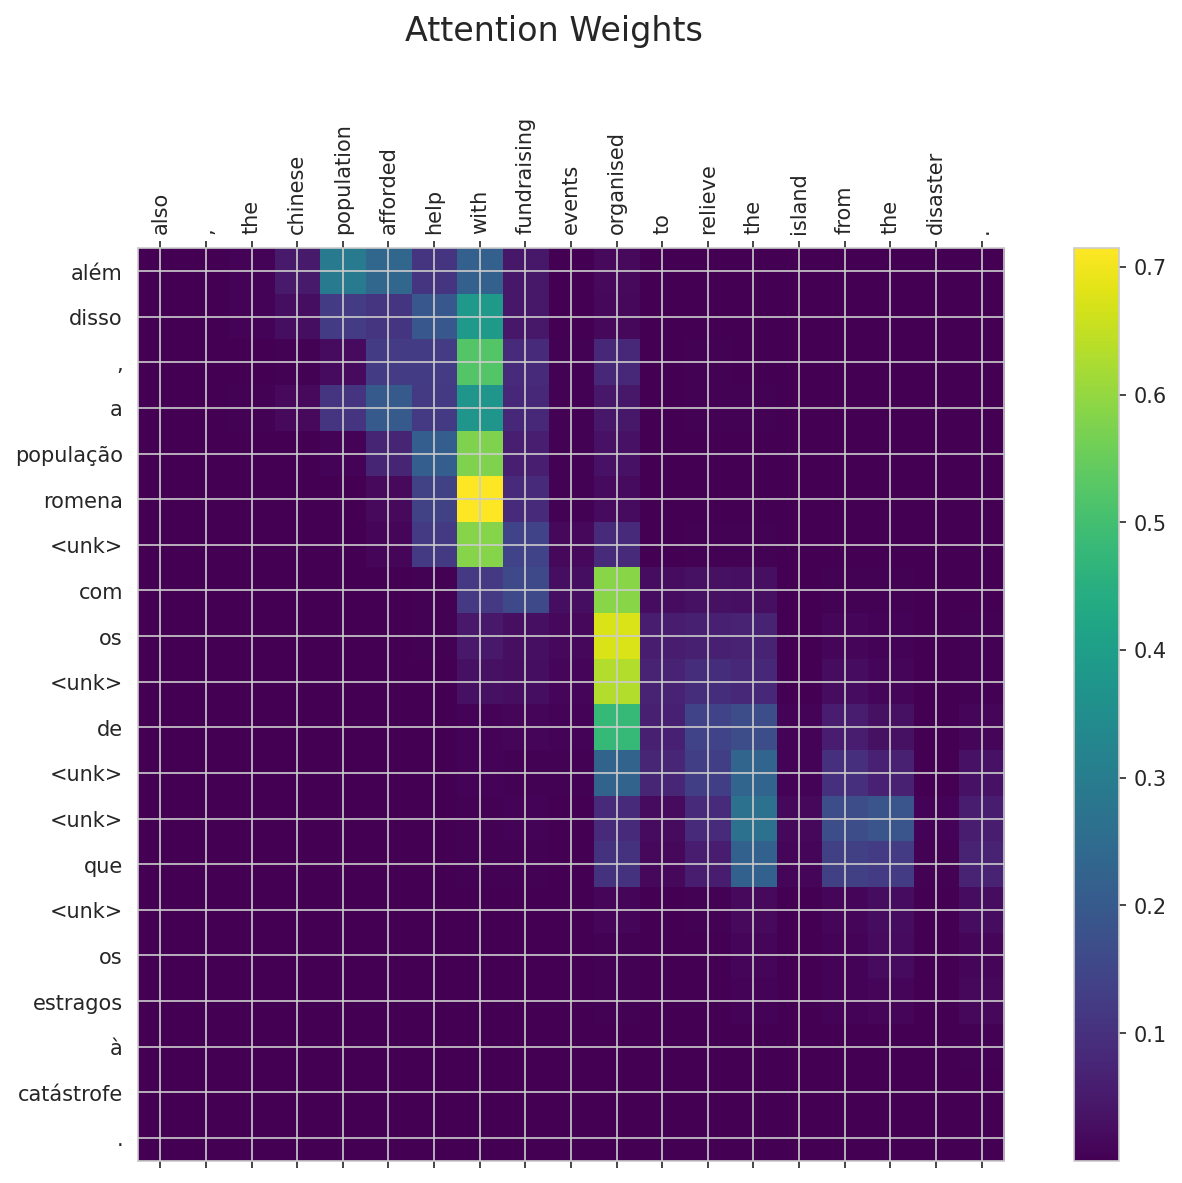

--------------------------------------------------
Original (EN): this agreement should be based on the principle of shared yet differentiated responsibility .
Reference (PT): o acordo deverá basear-se no princípio de uma responsabilidade comum , mas diferenciada .
Translation (Attention Model): esta questão deve ser incluída na base de uma declaração sobre o princípio da responsabilidade .


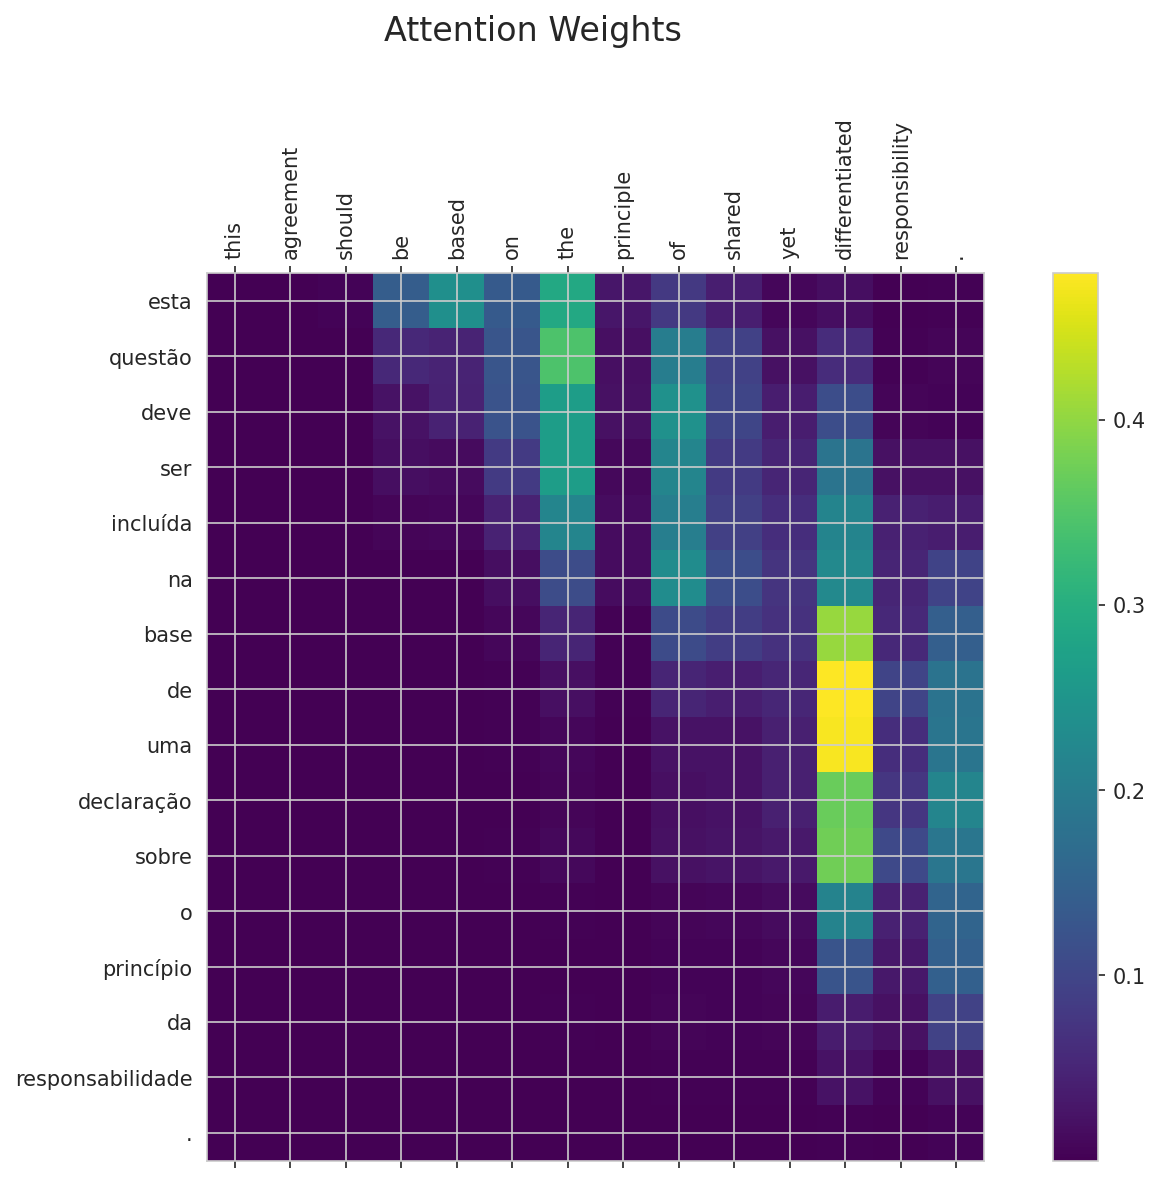

--------------------------------------------------
Original (EN): it follows that the original idea of combining the two agencies in one single agency for fundamental rights deserves support .
Reference (PT): donde se conclui que a ideia inicial de agrupar as duas agências numa única agência dos direitos fundamentais merece apoio .
Translation (Attention Model): é o que a proposta inicial da comissão dos dois estados-membros da ue , uma única prioridade , merece um apoio .


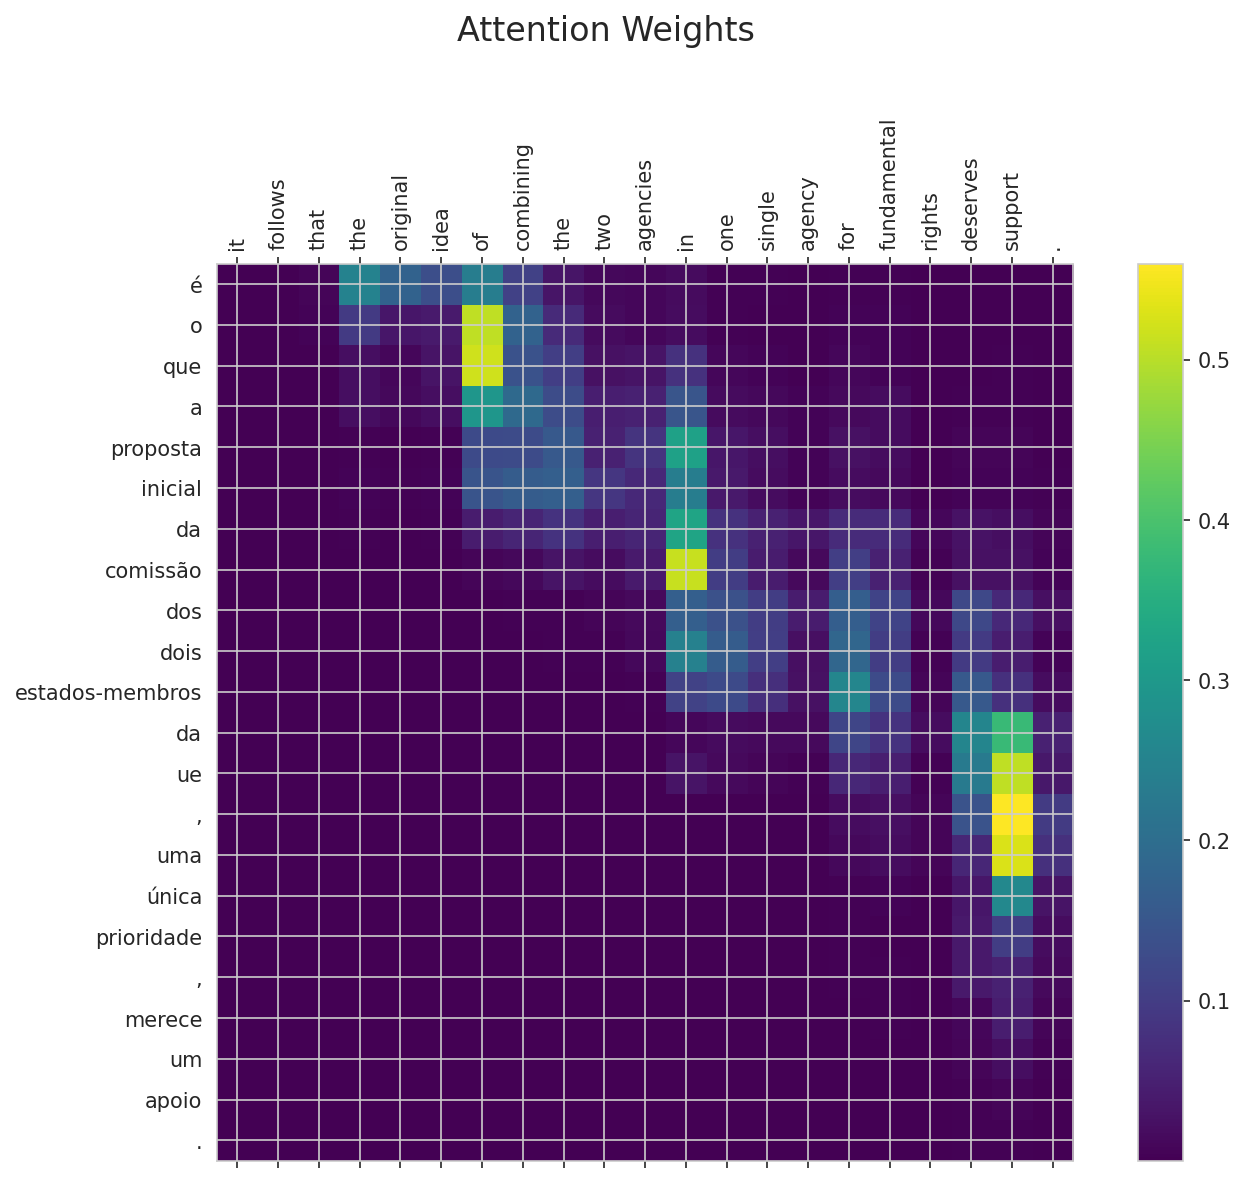

In [36]:
def translate_and_visualize_attention(input_seq):
    """
    Translates an input sequence using the inference models and returns the
    translation along with the attention weights for visualization.
    """
    # Run the encoder on the input sequence to get its output and final states.
    encoder_out, state_h, state_c = encoder_model_att.predict(input_seq, verbose=0)
    # The encoder's final states are used as the initial states for the decoder.
    states_value = [state_h, state_c]

    # Initialize the decoder's input sequence with the start-of-sentence ('<sos>') token.
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = pt_tokenizer.word_index['<sos>']

    # Initialize an empty string for the decoded sentence.
    decoded_sentence = ''
    # Create an empty matrix to store the attention weights for each decoding step.
    attention_plot = np.zeros((max_pt_len, max_en_len))

    # Loop to generate the translation token by token, up to the maximum possible length.
    for t in range(max_pt_len):
        # Predict the next token using the decoder model.
        # It takes the previous token, the full encoder output, and the current decoder states as input.
        output_tokens, new_states, attention = decoder_model_att.predict(
            [target_seq, encoder_out, states_value], verbose=0
        )

        # Store the calculated attention weights for the current timestep 't'.
        attention_plot[t] = attention[0, 0, :]

        # Find the token with the highest probability in the output.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Convert the token index back to a word.
        sampled_word = reverse_pt_word_index.get(sampled_token_index, '<unk>')

        # If the model predicts the end-of-sentence ('<eos>') token, stop the loop.
        if (sampled_word == '<eos>'):
            break

        # Append the predicted word to the sentence.
        decoded_sentence += ' ' + sampled_word

        # Prepare the inputs for the next iteration of the loop.
        # The predicted token becomes the input for the next step.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # The decoder's states are updated.
        states_value = new_states

    # Return the final translated sentence and the matrix of attention weights.
    return decoded_sentence.strip(), attention_plot


def plot_attention(attention, original_sentence, translated_sentence):
    """
    Visualizes the attention weights as a heatmap.
    """
    # Split the sentences into words to use as labels for the axes.
    original_tokens = original_sentence.split(' ')
    translated_tokens = translated_sentence.split(' ')
    
    # Trim the attention matrix to the actual lengths of the sentences, removing padding.
    attention_matrix = attention[:len(translated_tokens), :len(original_tokens)]

    # Set up the plot figure.
    fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
    # Create the heatmap from the attention matrix.
    cax = ax.matshow(attention_matrix, cmap='viridis')
    # Add a color bar to show the scale of the weights.
    fig.colorbar(cax)

    # Set the ticks and labels for the x-axis (the original English sentence).
    ax.set_xticks(range(len(original_tokens)))
    ax.set_xticklabels(original_tokens, rotation=90)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    # Set the ticks and labels for the y-axis (the translated Portuguese sentence).
    ax.set_yticks(range(len(translated_tokens)))
    ax.set_yticklabels(translated_tokens)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add a title and display the plot.
    plt.suptitle("Attention Weights", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- Find and Visualize Attention for Suitable Sentences ---

# Announce the start of the process.
print("\n--- Searching for suitable sentences for Attention Visualization ---")

# Calculate the word count for each sentence to enable filtering.
val_df['en_len'] = val_df['en_sentence'].apply(lambda x: len(x.split()))

# Define the ideal length range for a clear visualization.
min_len = 15
max_len = 25

# Filter the DataFrame to get the indices of sentences that match the length criteria.
suitable_indices = val_df[
    (val_df['en_len'] >= min_len) & (val_df['en_len'] <= max_len)
].index.tolist()

# Check if any suitable sentences were found.
if not suitable_indices:
    # If not, fall back to using the first 3 sentences.
    print(f"No sentences found in the ideal length range ({min_len}-{max_len} words). Taking the first 3 sentences as a fallback.")
    indices_to_show = range(3)
else:
    # If found, select the first 3 suitable sentences for display.
    print(f"Found {len(suitable_indices)} sentences with a length between {min_len} and {max_len} words.")
    indices_to_show = suitable_indices[:3]


# --- Run translation and visualization on the selected sentences ---
print("\n--- Translations & Attention with the final Attention Model ---")

# Loop through the indices of the sentences selected for visualization.
for i in indices_to_show:
    # Use a try-except block to safely handle any potential index errors.
    try:
        # Get the integer position (.iloc) for the numpy array from the DataFrame's index label ('i').
        iloc_position = val_df.index.get_loc(i)
        
        # Prepare the specific sentence's padded sequence for the model.
        input_seq = val_en_padded[iloc_position:iloc_position+1]
        
        # Retrieve the original text sentences for display, cleaning out special tokens.
        original_sentence = val_df.loc[i, 'en_sentence'].replace('<sos>', '').replace('<eos>', '').strip()
        target_sentence = val_df.loc[i, 'pt_sentence'].replace('<sos>', '').replace('<eos>', '').strip()

        # Generate the translation and the attention weights.
        translation, attention_plot = translate_and_visualize_attention(input_seq)

        # Print the results.
        print('-'*50)
        print('Original (EN):', original_sentence)
        print('Reference (PT):', target_sentence)
        print('Translation (Attention Model):', translation)
        
        # Only plot if the model produced a non-empty translation.
        if translation:
            plot_attention(attention_plot, original_sentence, translation)
        else:
            print("Skipping plot because translation is empty.")

    except KeyError:
        # If an index is not found, print a message and continue.
        print(f"Index {i} not found in val_df. Skipping.")

# --- Task 3 & 4 Models Evaluation (BLEU & METEOR) ---

In [37]:
# --- Batch Translation and Evaluation Script ---

def batch_translate(input_padded, encoder_model, decoder_model, max_target_len, target_tokenizer):
    """
    Translates a batch of sequences using encoder-decoder models.
    This function is compatible with both standard and attention-based architectures.
    """
    # Get the number of sequences in the batch.
    batch_size = input_padded.shape[0]

    # Get the initial hidden and cell states from the encoder.
    encoder_outputs_states = encoder_model.predict(input_padded, verbose=0)

    # Check if the model uses attention by inspecting the encoder's output shape.
    # An attention model returns a list of [encoder_output, state_h, state_c].
    is_attention_model = (
        isinstance(encoder_outputs_states, list) and
        len(encoder_outputs_states) == 3
    )

    # Unpack encoder outputs based on the model type.
    if is_attention_model:
        encoder_out, state_h, state_c = encoder_outputs_states
        states_value = [state_h, state_c]
    else:
        states_value = encoder_outputs_states # For non-attention models.

    # Initialize the decoder input with the start-of-sequence token '<sos>'.
    target_seq = np.full((batch_size, 1), target_tokenizer.word_index['<sos>'])
    
    # Create an empty array to store the decoded sequences.
    decoded_sequences = np.zeros((batch_size, max_target_len), dtype='int32')

    # Generate the translation word by word.
    for t in range(max_target_len):
        if is_attention_model:
            # The attention decoder requires the target sequence, encoder outputs, and states.
            decoder_outputs = decoder_model.predict(
                [target_seq, encoder_out] + states_value, verbose=0
            )
            output_tokens = decoder_outputs[0]
            states_value = [decoder_outputs[1], decoder_outputs[2]] # Update states.
        else:
            # The standard decoder requires the target sequence and previous states.
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
            states_value = [h, c] # Update states.

        # Select the token with the highest probability (greedy search).
        sampled_token_indices = np.argmax(output_tokens, axis=-1)
        
        # Store the predicted token and set it as the next input for the decoder.
        decoded_sequences[:, t] = sampled_token_indices.flatten()
        target_seq = sampled_token_indices

    # Convert the token indices back to readable sentences.
    decoded_sentences = []
    reverse_target_word_index = {v: k for k, v in target_tokenizer.word_index.items()}

    for seq in decoded_sequences:
        sentence = []
        for token_index in seq:
            word = reverse_target_word_index.get(token_index)
            # Stop decoding if the end-of-sequence token is found.
            if word == '<eos>':
                break
            # Append the word if it's not a special token.
            if word and word not in ['<unk>', '<sos>']:
                sentence.append(word)
        decoded_sentences.append(" ".join(sentence))

    return decoded_sentences

# ---

def batch_translate_char(input_padded, encoder_model, decoder_model, max_target_len, target_tokenizer):
    """Translates a batch of sequences for character-based models."""
    batch_size = input_padded.shape[0]
    
    # Get initial states from the character encoder.
    states_value = encoder_model.predict(input_padded, verbose=0)

    # Initialize decoder input with the start token (typically '<').
    start_token_index = target_tokenizer.word_index.get('<', target_tokenizer.word_index.get(' ', 1))
    target_seq = np.full((batch_size, 1), start_token_index)

    # Generate the translated characters step-by-step.
    decoded_indices = []
    for _ in range(max_target_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        states_value = [h, c]
        
        # Select the character with the highest probability.
        sampled_token_indices = np.argmax(output_tokens, axis=-1)
        decoded_indices.append(sampled_token_indices.flatten())
        target_seq = sampled_token_indices

    # Convert the list of decoded indices into a 2D numpy array.
    decoded_indices = np.array(decoded_indices).T
    reverse_target_char_index = {v: k for k, v in target_tokenizer.word_index.items()}

    # Reconstruct the sentences from the character indices.
    decoded_sentences = []
    for seq in decoded_indices:
        sentence = ""
        for token_index in seq:
            char = reverse_target_char_index.get(token_index, '')
            # A common stop condition for char models might involve a sequence like '<eos>'.
            if char == '>' and sentence.endswith('<eos'):
                break
            sentence += char
        # Clean up special tokens from the final sentence.
        cleaned_sentence = sentence.replace('<sos>', '').replace('<eos>', '').strip()
        decoded_sentences.append(cleaned_sentence)

    return decoded_sentences

# --- Setup Caching and Evaluation Data ---

# Define a directory to cache generated translations (hypotheses).
output_cache_dir = '/kaggle/working/hypotheses_cache/'

# Clear the cache directory to ensure fresh results.
if os.path.exists(output_cache_dir):
    print(f"Removing old cache directory: {output_cache_dir}")
    shutil.rmtree(output_cache_dir)
os.makedirs(output_cache_dir, exist_ok=True)
print("Created new empty cache directory.")

# Create a smaller, representative test set for faster evaluation.
eval_sample_size = 1000
eval_test_df = test_df.sample(n=eval_sample_size, random_state=42)

# Prepare and pad the evaluation data for all model types (word and character).
eval_en_seq = en_tokenizer.texts_to_sequences(eval_test_df['en_sentence'])
eval_pt_seq = pt_tokenizer.texts_to_sequences(eval_test_df['pt_sentence'])
eval_en_padded = pad_sequences(eval_en_seq, maxlen=max_en_len, padding='post')
eval_pt_padded = pad_sequences(eval_pt_seq, maxlen=max_pt_len, padding='post')
eval_en_char_seq = en_char_tokenizer.texts_to_sequences(eval_test_df['en_sentence'])
eval_en_char_padded = pad_sequences(eval_en_char_seq, maxlen=max_en_char_len, padding='post')

# --- Evaluation Loop Setup ---

# Define batch size for evaluation to manage memory usage.
EVAL_BATCH_SIZE = 1024
results = {}

# Directory where pre-generated hypotheses might be stored.
input_cache_dir = '/kaggle/input/hypotheses/hypotheses_cache/'

# Prepare reference sentences for metric calculation (BLEU, METEOR).
references_pt_raw = eval_test_df['pt_sentence'].tolist()
references_pt_tokenized = [[sent.replace('<sos>', '').replace('<eos>', '').strip().split()] for sent in references_pt_raw]
references_en_raw = eval_test_df['en_sentence'].tolist()
references_en_tokenized = [[sent.replace('<sos>', '').replace('<eos>', '').strip().split()] for sent in references_en_raw]

# Initialize the Sacrebleu metric calculator.
sacrebleu_metric = SacrebleuBLEU()

# Define all word-based models to be evaluated.
models_to_evaluate = {
    "Base Model (EN->PT)": (eval_en_padded, encoder_model_base, decoder_model_base, max_pt_len, pt_tokenizer, references_pt_tokenized),
    "GloVe Model (EN->PT)": (eval_en_padded, encoder_model_glove, decoder_model_glove, max_pt_len, pt_tokenizer, references_pt_tokenized),
    "Word2Vec Model (EN->PT)": (eval_en_padded, encoder_model_w2v, decoder_model_w2v, max_pt_len, pt_tokenizer, references_pt_tokenized),
    "Attention Model (EN->PT)": (eval_en_padded, encoder_model_att, decoder_model_att, max_pt_len, pt_tokenizer, references_pt_tokenized),
    "Base Model (PT->EN)": (eval_pt_padded, encoder_model_pt_to_en, decoder_model_pt_to_en, max_en_len, en_tokenizer, references_en_tokenized),
}

# --- Evaluate Word-Based Models ---

for model_name, (input_data, encoder, decoder, max_len, tokenizer, references_tokenized) in models_to_evaluate.items():
    print(f"--- Evaluating {model_name} ---")

    # Define file paths for caching translation results.
    cache_filename = model_name.replace(" ", "_").replace("->", "to") + "_1k.json"
    input_cache_filepath = os.path.join(input_cache_dir, cache_filename)
    output_cache_filepath = os.path.join(output_cache_dir, cache_filename)

    hypotheses = []
    load_path = None
    
    # Check if translations are already cached to save time.
    if os.path.exists(input_cache_filepath):
        load_path = input_cache_filepath
    elif os.path.exists(output_cache_filepath):
        load_path = output_cache_filepath

    if load_path:
        print(f"Loading cached hypotheses from '{load_path}'...")
        with open(load_path, 'r') as f:
            hypotheses = json.load(f)
    else:
        # If no cache is found, generate translations now.
        print("Generating hypotheses (no cache found)...")
        for i in tqdm(range(0, len(input_data), EVAL_BATCH_SIZE)):
            batch_input = input_data[i : i + EVAL_BATCH_SIZE]
            batch_translations = batch_translate(batch_input, encoder, decoder, max_len, tokenizer)
            hypotheses.extend(batch_translations)
        
        # Save the newly generated translations to the cache.
        print(f"Saving hypotheses to '{output_cache_filepath}'...")
        with open(output_cache_filepath, 'w') as f:
            json.dump(hypotheses, f)

    # Perform a detailed sentence-level analysis for each model.
    print(f"\n   >>> Performing detailed sentence-level analysis for {model_name}...")
    detailed_results = []
    
    # Select the correct source and reference sentences based on the translation direction.
    if "(EN->PT)" in model_name:
        source_sentences_raw = eval_test_df['en_sentence'].tolist()
        reference_sentences_raw = eval_test_df['pt_sentence'].tolist()
    else: # Assumes PT->EN otherwise.
        source_sentences_raw = eval_test_df['pt_sentence'].tolist()
        reference_sentences_raw = eval_test_df['en_sentence'].tolist()

    # Calculate sentence-level metrics and collect detailed data.
    for src, ref, pred in zip(source_sentences_raw, reference_sentences_raw, hypotheses):
        sentence_bleu = sacrebleu_metric.sentence_score(pred, [ref]).score
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        sentence_meteor = meteor_score([ref_tokens], pred_tokens)
        
        detailed_results.append({
            'source_sentence': src,
            'reference_translation': ref,
            'model_prediction': pred,
            'sentence_bleu': sentence_bleu,
            'sentence_meteor': sentence_meteor,
            'source_length': len(src.split()),
            'reference_length': len(ref_tokens),
            'prediction_length': len(pred_tokens)
        })
        
    # Save the detailed analysis to a CSV file.
    detailed_df = pd.DataFrame(detailed_results)
    safe_model_name = model_name.replace(" ", "_").replace("->", "to").replace("(", "").replace(")", "")
    csv_path = f'detailed_analysis_{safe_model_name}.csv'
    detailed_df.to_csv(csv_path, index=False)
    print(f"   >>> Detailed analysis saved to '{csv_path}'")
    
    # Analyze how model performance changes with sentence length.
    print(f"   >>> Analyzing performance vs. sentence length for {model_name}...")
    bins = [0, 10, 20, 35, 50, float('inf')]
    labels = ['1-10 (short)', '11-20 (medium)', '21-35 (long)', '36-50 (very long)', '51+ (extremely long)']
    detailed_df['length_bucket'] = pd.cut(detailed_df['source_length'], bins=bins, labels=labels, right=True)
    length_performance = detailed_df.groupby('length_bucket').agg(
        avg_bleu=('sentence_bleu', 'mean'),
        avg_meteor=('sentence_meteor', 'mean'),
        sentence_count=('source_length', 'size')
    ).reset_index()
    
    print("\n   --- Performance by Source Sentence Length ---")
    print(length_performance.to_string())
    print("   ---------------------------------------------\n")

    # Calculate and store corpus-level BLEU and METEOR scores.
    tokenized_hyps = [h.split() for h in hypotheses]
    bleu = corpus_bleu(references_tokenized, tokenized_hyps)
    meteor_scores = [meteor_score(ref, hyp) for ref, hyp in zip(references_tokenized, tokenized_hyps)]
    meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    results[model_name] = {"BLEU": bleu * 100, "METEOR": meteor * 100}

# --- Evaluate Character-Based Model ---

print("\n--- Evaluating Character-Based Model (EN->PT) ---")
char_model_name = "Character Model (EN->PT)"

# Define cache paths for the character model.
char_cache_filename = char_model_name.replace(" ", "_").replace("->", "to") + "_1k.json"
char_input_cache_filepath = os.path.join(input_cache_dir, char_cache_filename)
char_output_cache_filepath = os.path.join(output_cache_dir, char_cache_filename)
char_hypotheses = []
char_load_path = None

# Check for a cached version of the translations.
if os.path.exists(char_input_cache_filepath):
    char_load_path = char_input_cache_filepath
elif os.path.exists(char_output_cache_filepath):
    char_load_path = char_output_cache_filepath

if char_load_path:
    print(f"Loading cached hypotheses from '{char_load_path}'...")
    with open(char_load_path, 'r') as f:
        char_hypotheses = json.load(f)
else:
    # Generate translations if no cache is found.
    print("Generating character-based hypotheses (no cache found)...")
    for i in tqdm(range(0, len(eval_en_char_padded), EVAL_BATCH_SIZE)):
        batch_input = eval_en_char_padded[i : i + EVAL_BATCH_SIZE]
        batch_translations = batch_translate_char(
            batch_input, encoder_model_char, decoder_model_char, max_pt_char_len, pt_char_tokenizer
        )
        char_hypotheses.extend(batch_translations)
        
    # Save the new translations to the cache.
    print(f"Saving hypotheses to '{char_output_cache_filepath}'...")
    with open(char_output_cache_filepath, 'w') as f:
        json.dump(char_hypotheses, f)
        
# Perform detailed sentence-level analysis for the character model.
print(f"\n   >>> Performing detailed sentence-level analysis for {char_model_name}...")
char_detailed_results = []
source_sentences_raw = eval_test_df['en_sentence'].tolist()
reference_sentences_raw = eval_test_df['pt_sentence'].tolist()

for src, ref, pred in zip(source_sentences_raw, reference_sentences_raw, char_hypotheses):
    sentence_bleu = sacrebleu_metric.sentence_score(pred, [ref]).score
    ref_tokens = ref.split()
    pred_tokens = pred.split()
    sentence_meteor = meteor_score([ref_tokens], pred_tokens)

    char_detailed_results.append({
        'source_sentence': src,
        'reference_translation': ref,
        'model_prediction': pred,
        'sentence_bleu': sentence_bleu,
        'sentence_meteor': sentence_meteor,
        'source_length': len(src.split()),
        'reference_length': len(ref_tokens),
        'prediction_length': len(pred_tokens)
    })
    
# Save the detailed analysis to a CSV file.
char_detailed_df = pd.DataFrame(char_detailed_results)
char_safe_model_name = char_model_name.replace(" ", "_").replace("->", "to").replace("(", "").replace(")", "")
char_csv_path = f'detailed_analysis_{char_safe_model_name}.csv'
char_detailed_df.to_csv(char_csv_path, index=False)
print(f"   >>> Detailed analysis saved to '{char_csv_path}'")

# Analyze the influence of text length for the character model.
print(f"   >>> Analyzing performance vs. sentence length for {char_model_name}...")
char_detailed_df['length_bucket'] = pd.cut(char_detailed_df['source_length'], bins=bins, labels=labels, right=True)
char_length_performance = char_detailed_df.groupby('length_bucket').agg(
    avg_bleu=('sentence_bleu', 'mean'),
    avg_meteor=('sentence_meteor', 'mean'),
    sentence_count=('source_length', 'size')
).reset_index()

print("\n   --- Performance by Source Sentence Length ---")
print(char_length_performance.to_string())
print("   ---------------------------------------------\n")

# Calculate and store corpus-level scores for the character model.
tokenized_char_hyps = [h.split() for h in char_hypotheses]
bleu_char = corpus_bleu(references_pt_tokenized, tokenized_char_hyps)
meteor_scores_char = [meteor_score(ref, hyp) for ref, hyp in zip(references_pt_tokenized, tokenized_char_hyps)]
meteor_char = sum(meteor_scores_char) / len(meteor_scores_char) if meteor_scores_char else 0
results[char_model_name] = {"BLEU": bleu_char * 100, "METEOR": meteor_char * 100}

# --- Display Final Results ---

# Consolidate all results into a single DataFrame.
results_df = pd.DataFrame(results).T.sort_values(by="BLEU", ascending=False)
results_df.index.name = "Model"
print("\n--- Final Evaluation Results (on 1000 sentences) ---\n")

# Display results for English to Portuguese models.
print("\n--- EN -> PT Translation ---\n")
print(results_df[results_df.index.str.contains('EN->PT')])

# Display results for Portuguese to English models.
print("\n--- PT -> EN Translation ---\n")
print(results_df[results_df.index.str.contains('PT->EN')])

Created new empty cache directory.
--- Evaluating Base Model (EN->PT) ---
Loading cached hypotheses from '/kaggle/input/hypotheses/hypotheses_cache/Base_Model_(ENtoPT)_1k.json'...

   >>> Performing detailed sentence-level analysis for Base Model (EN->PT)...
   >>> Detailed analysis saved to 'detailed_analysis_Base_Model_ENtoPT.csv'
   >>> Analyzing performance vs. sentence length for Base Model (EN->PT)...

   --- Performance by Source Sentence Length ---
          length_bucket  avg_bleu  avg_meteor  sentence_count
0          1-10 (short)  4.392868    0.175496              65
1        11-20 (medium)  3.605334    0.136624             232
2          21-35 (long)  3.318435    0.145085             402
3     36-50 (very long)  3.306687    0.156808             192
4  51+ (extremely long)  2.706203    0.161951             109
   ---------------------------------------------

--- Evaluating GloVe Model (EN->PT) ---
Loading cached hypotheses from '/kaggle/input/hypotheses/hypotheses_cache/Glo

# ✅ Bonus Task 5: Pivot Translation (+15%)

## 5.1 Pivot Task Setup: Data Loading, Merging & Splitting

In [38]:
# Load the Portuguese-English dataset, which has already been filtered to ensure that no sentence is longer than 100 tokens.
df_pt_en = pd.read_parquet('/kaggle/input/preprocessed-accurate/preprocessed_accurate.parquet')

# Set the file paths for the Swedish-English dataset, checking both a working directory and a Kaggle input directory.
sv_en_parquet_path = '/kaggle/working/preprocessed_sv_en.parquet'
sv_en_parquet_kaggle_path = '/kaggle/input/preprocessed-accurate/preprocessed_sv_en.parquet'

# If a preprocessed Swedish-English dataset exists in the working directory, load it.
if os.path.exists(sv_en_parquet_path):
    print(f"Loading cached preprocessed English-Swedish data from '{sv_en_parquet_path}'...")
    df_sv_en = pd.read_parquet(sv_en_parquet_path)
# If not, check if it exists in the Kaggle input directory and load it if found.
elif os.path.exists(sv_en_parquet_kaggle_path):
    print(f"Loading cached preprocessed English-Swedish data from '{sv_en_parquet_kaggle_path}'...")
    df_sv_en = pd.read_parquet(sv_en_parquet_kaggle_path)
# If neither file exists, process the raw Swedish-English data files.
else:
    print("Cached English-Swedish data not found. Processing from raw files...")
    en_sv_file_path = '/kaggle/input/europarl-dataset-en-sv/europarl-v7.sv-en.en'
    sv_en_file_path = '/kaggle/input/europarl-dataset-en-sv/europarl-v7.sv-en.sv'

    # Read the English and Swedish sentences from their respective files, removing any leading or trailing whitespace.
    with open(en_sv_file_path, 'r', encoding='utf-8') as f:
        en_pivot_sentences = [line.strip() for line in f.readlines()]
    with open(sv_en_file_path, 'r', encoding='utf-8') as f:
        sv_sentences = [line.strip() for line in f.readlines()]

    # Create a DataFrame with the English and Swedish sentences.
    df_sv_en = pd.DataFrame({'en_sentence': en_pivot_sentences, 'sv_sentence': sv_sentences})
    
    # Apply the text preprocessing function to both the English and Swedish sentences.
    print("Applying preprocess_text function to raw SV-EN data...")
    df_sv_en['en_sentence'] = df_sv_en['en_sentence'].apply(preprocess_text)
    df_sv_en['sv_sentence'] = df_sv_en['sv_sentence'].apply(preprocess_text)
    # Remove any rows with missing values or empty strings in either language.
    df_sv_en.dropna(inplace=True)
    df_sv_en = df_sv_en[(df_sv_en['en_sentence'] != '') & (df_sv_en['sv_sentence'] != '')]

    # Filter out any sentence pairs where either sentence is longer than 100 tokens.
    print("Applying sentence length filter (max 100 tokens)...")
    max_sentence_length = 100
    df_sv_en['en_len'] = df_sv_en['en_sentence'].str.split().str.len()
    df_sv_en['sv_len'] = df_sv_en['sv_sentence'].str.split().str.len()
    df_sv_en = df_sv_en[(df_sv_en['en_len'] <= max_sentence_length) & (df_sv_en['sv_len'] <= max_sentence_length)]
    df_sv_en = df_sv_en.drop(columns=['en_len', 'sv_len'])

    # Add special start-of-sentence and end-of-sentence tokens to both the English and Swedish sentences.
    df_sv_en['en_sentence'] = df_sv_en['en_sentence'].apply(lambda s: f'<sos> {s} <eos>')
    df_sv_en['sv_sentence'] = df_sv_en['sv_sentence'].apply(lambda s: f'<sos> {s} <eos>')

    # Save the newly preprocessed Swedish-English data for future use.
    print(f"Saving newly preprocessed data to '{sv_en_parquet_path}'...")
    df_sv_en.to_parquet(sv_en_parquet_path, index=False)

# Remove the special tokens from the English sentences in both datasets to create a clean version for merging.
print("\n--- Step 2: Merging corpora to create a trilingual dataset ---")
df_pt_en['en_sentence_clean'] = df_pt_en['en_sentence'].str.replace('<sos>|<eos>', '', regex=True).str.strip()
df_sv_en['en_sentence_clean'] = df_sv_en['en_sentence'].str.replace('<sos>|<eos>', '', regex=True).str.strip()

# Merge the Portuguese-English and Swedish-English datasets on the cleaned English sentences to create a trilingual dataset.
df_trilingual = pd.merge(
    df_pt_en[['pt_sentence', 'en_sentence', 'en_sentence_clean']],
    df_sv_en[['sv_sentence', 'en_sentence_clean']],
    on='en_sentence_clean',
    how='inner'
)
# Remove the column used for merging, drop duplicate rows, and reset the index.
df_trilingual = df_trilingual.drop(columns=['en_sentence_clean']).drop_duplicates().reset_index(drop=True)
print(f"Found {len(df_trilingual)} unique parallel sentences.")

# If the trilingual dataset is larger than 50,000 samples, randomly select 50,000 samples for faster training.
print("\n--- Step 3: Limiting total dataset size for faster training ---")
sample_size = 50000
if len(df_trilingual) > sample_size:
    df_trilingual_sampled = df_trilingual.sample(n=sample_size, random_state=42)
    print(f"Using a random sample of {len(df_trilingual_sampled)} sentences.")
else:
    df_trilingual_sampled = df_trilingual
    print(f"Using the full dataset of {len(df_trilingual_sampled)} sentences (less than {sample_size}).")

# Split the sampled trilingual dataset into a training set (90%) and a test set (10%).
print("\n--- Step 4: Splitting into a global train and test set (90% train / 10% test) ---")
trilingual_train_df, trilingual_test_df = train_test_split(
    df_trilingual_sampled,
    test_size=0.1,
    random_state=42
)

# Print the sizes of the training and test sets, and confirm that the setup is complete.
print(f"Global training set size: {len(trilingual_train_df)}")
print(f"Global held-out test set size: {len(trilingual_test_df)}")

print("\nSetup complete. The data is now filtered, limited, and correctly split.")

Loading cached preprocessed English-Swedish data from '/kaggle/input/preprocessed-accurate/preprocessed_sv_en.parquet'...

--- Step 2: Merging corpora to create a trilingual dataset ---
Found 89392 unique parallel sentences.

--- Step 3: Limiting total dataset size for faster training ---
Using a random sample of 50000 sentences.

--- Step 4: Splitting into a global train and test set (90% train / 10% test) ---
Global training set size: 45000
Global held-out test set size: 5000

Setup complete. The data is now filtered, limited, and correctly split.


## 5.2 Preparing the training data for both Pivot-Models

In [39]:
# Prepare tokenizers for the pivot models. We use the existing English and Portuguese tokenizers, and create a new Swedish tokenizer using only the training data.
print("--- Step 1: Preparing tokenizers ---")

num_most_frequent_words = 20000
sv_tokenizer = Tokenizer(filters='', num_words=num_most_frequent_words, oov_token="<unk>")
sv_tokenizer.fit_on_texts(trilingual_train_df['sv_sentence'])
sv_vocab_size = len(sv_tokenizer.word_index) + 1
reverse_sv_word_index = {v: k for k, v in sv_tokenizer.word_index.items()}

print(f"Swedish vocabulary size: {sv_vocab_size}")

# Convert the training set sentences to sequences of integers using the fitted tokenizers.
print("\n--- Step 2: Converting text to sequences using the fitted tokenizers ---")

train_pt_seq = pt_tokenizer.texts_to_sequences(trilingual_train_df['pt_sentence'])
train_en_seq = en_tokenizer.texts_to_sequences(trilingual_train_df['en_sentence'])
train_sv_seq = sv_tokenizer.texts_to_sequences(trilingual_train_df['sv_sentence'])

# Pad all sequences so that they have the same length, determined by the longest sequence in the training data for each language.
print("\n--- Step 3: Padding sequences based on max length from the training data ---")

max_pt_len_pivot = max(len(s) for s in train_pt_seq)
max_en_len_pivot = max(len(s) for s in train_en_seq)
max_sv_len_pivot = max(len(s) for s in train_sv_seq)

print(f"Max PT length for pivot training: {max_pt_len_pivot}")
print(f"Max EN length for pivot training: {max_en_len_pivot}")
print(f"Max SV length for pivot training: {max_sv_len_pivot}")

train_pt_padded = pad_sequences(train_pt_seq, maxlen=max_pt_len_pivot, padding='post')
train_en_padded = pad_sequences(train_en_seq, maxlen=max_en_len_pivot, padding='post')
train_sv_padded = pad_sequences(train_sv_seq, maxlen=max_sv_len_pivot, padding='post')

# Create the target data for the decoder by shifting the padded sequences by one position, for use in teacher forcing during training.
print("\n--- Step 4: Creating decoder target data for teacher forcing ---")

decoder_target_en = np.zeros_like(train_en_padded)
decoder_target_en[:, :-1] = train_en_padded[:, 1:]

decoder_target_sv = np.zeros_like(train_sv_padded)
decoder_target_sv[:, :-1] = train_sv_padded[:, 1:]

print(f"\nShape of PT source data for training: {train_pt_padded.shape}")
print(f"Shape of EN target data for training: {decoder_target_en.shape}")
print("-" * 20)
print(f"Shape of EN source data for training: {train_en_padded.shape}")
print(f"Shape of SV target data for training: {decoder_target_sv.shape}")
print("\nData preparation for pivot model training is complete.")

pivot_train_df, pivot_val_df = train_test_split(
    trilingual_train_df,
    test_size=0.1,
    random_state=42
)

print(f"Size of new pivot training set: {len(pivot_train_df)}")
print(f"Size of new pivot validation set: {len(pivot_val_df)}")

# Convert the validation set sentences to sequences using the same tokenizers.
val_pt_seq = pt_tokenizer.texts_to_sequences(pivot_val_df['pt_sentence'])
val_en_seq = en_tokenizer.texts_to_sequences(pivot_val_df['en_sentence'])
val_sv_seq = sv_tokenizer.texts_to_sequences(pivot_val_df['sv_sentence'])

# Pad the validation sequences to the same maximum lengths as the training data.
val_pt_padded = pad_sequences(val_pt_seq, maxlen=max_pt_len_pivot, padding='post')
val_en_padded = pad_sequences(val_en_seq, maxlen=max_en_len_pivot, padding='post')
val_sv_padded = pad_sequences(val_sv_seq, maxlen=max_sv_len_pivot, padding='post')

# Create the target data for the decoder for the validation set by shifting the padded sequences by one position.
val_decoder_target_en = np.zeros_like(val_en_padded)
val_decoder_target_en[:, :-1] = val_en_padded[:, 1:]

val_decoder_target_sv = np.zeros_like(val_sv_padded)
val_decoder_target_sv[:, :-1] = val_sv_padded[:, 1:]

print("\nValidation data for both pivot models created successfully.")

--- Step 1: Preparing tokenizers ---
Swedish vocabulary size: 47281

--- Step 2: Converting text to sequences using the fitted tokenizers ---

--- Step 3: Padding sequences based on max length from the training data ---
Max PT length for pivot training: 100
Max EN length for pivot training: 100
Max SV length for pivot training: 100

--- Step 4: Creating decoder target data for teacher forcing ---

Shape of PT source data for training: (45000, 100)
Shape of EN target data for training: (45000, 100)
--------------------
Shape of EN source data for training: (45000, 100)
Shape of SV target data for training: (45000, 100)

Data preparation for pivot model training is complete.
Size of new pivot training set: 40500
Size of new pivot validation set: 4500

Validation data for both pivot models created successfully.


## 5.3 Training the PT → EN Attention Model

In [40]:
# Define and train the Portuguese to English (PT -> EN) attention-based sequence-to-sequence model

print("--- Step 1: Building the PT -> EN Attention Model ---")
K.clear_session()

# Set model hyperparameters
embedding_dim = 256
latent_dim = 256

# Encoder for Portuguese input sequences
encoder_inputs_pt = Input(shape=(max_pt_len_pivot,), name="encoder_inputs_pt")
enc_emb_layer_pt = Embedding(pt_vocab_size, embedding_dim, name='encoder_embedding_pt')
enc_emb_pt = enc_emb_layer_pt(encoder_inputs_pt)
encoder_lstm_pt = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm_pt')
encoder_outputs_pt, state_h_pt, state_c_pt = encoder_lstm_pt(enc_emb_pt)
encoder_states_pt = [state_h_pt, state_c_pt]

# Decoder for English output sequences
decoder_inputs_en = Input(shape=(max_en_len_pivot,), name="decoder_inputs_en")
dec_emb_layer_en = Embedding(en_vocab_size, embedding_dim, name='decoder_embedding_en')
dec_emb_en = dec_emb_layer_en(decoder_inputs_en)
decoder_lstm_en = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm_en')
decoder_outputs_lstm_en, _, _ = decoder_lstm_en(dec_emb_en, initial_state=encoder_states_pt)

# Additive attention mechanism between decoder outputs and encoder outputs
attention_layer_pt_en = AdditiveAttention(name='attention_pt_en')
context_vector_pt_en = attention_layer_pt_en([decoder_outputs_lstm_en, encoder_outputs_pt])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs_lstm_en, context_vector_pt_en])

# Output layer for English vocabulary prediction
decoder_dense_en = Dense(en_vocab_size, activation='softmax', name='output_dense_en')
decoder_outputs_en = decoder_dense_en(decoder_concat_input)

# Build and compile the full PT -> EN model
model_pt_en_pivot = Model([encoder_inputs_pt, decoder_inputs_en], decoder_outputs_en, name='pt_en_pivot_model')
model_pt_en_pivot.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pt_en_pivot.summary()

print("\n--- Preparing Data for Training and Validation ---")

# Prepare training data using the reduced pivot training set
train_pt_seq_final = pt_tokenizer.texts_to_sequences(pivot_train_df['pt_sentence'])
train_en_seq_final = en_tokenizer.texts_to_sequences(pivot_train_df['en_sentence'])
train_pt_padded_final = pad_sequences(train_pt_seq_final, maxlen=max_pt_len_pivot, padding='post')
train_en_padded_final = pad_sequences(train_en_seq_final, maxlen=max_en_len_pivot, padding='post')
decoder_target_en_final = np.zeros_like(train_en_padded_final)
decoder_target_en_final[:, :-1] = train_en_padded_final[:, 1:]

train_dataset_pt_en = tf.data.Dataset.from_tensor_slices(
    ((train_pt_padded_final, train_en_padded_final), decoder_target_en_final)
).batch(64).prefetch(tf.data.AUTOTUNE)

# Prepare validation data
val_dataset_pt_en = tf.data.Dataset.from_tensor_slices(
    ((val_pt_padded, val_en_padded), val_decoder_target_en)
).batch(64).prefetch(tf.data.AUTOTUNE)

print("\n--- Training the PT -> EN Model with Callbacks ---")

# Define file paths for saving and loading model weights
pt_en_pivot_weights_path = '/kaggle/working/pt_en_pivot_model_best.weights.h5'
pt_en_pivot_weights_kaggle_path = '/kaggle/input/weights/pt_en_pivot_model_best.weights.h5'

# Define a callback to save only the best model based on lowest validation loss
checkpoint_callback = ModelCheckpoint(
    filepath=pt_en_pivot_weights_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define a callback to stop training if validation loss does not improve for 3 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Load existing best weights if available, otherwise train the model
if os.path.exists(pt_en_pivot_weights_path):
    print(f"Loading existing best weights from '{pt_en_pivot_weights_path}'...")
    model_pt_en_pivot.load_weights(pt_en_pivot_weights_path)
elif os.path.exists(pt_en_pivot_weights_kaggle_path):
    print(f"Loading existing best weights from '{pt_en_pivot_weights_kaggle_path}'...")
    model_pt_en_pivot.load_weights(pt_en_pivot_weights_kaggle_path)
else:
    print("Starting model training (no best weights found)...")
    history_pt_en = model_pt_en_pivot.fit(
        train_dataset_pt_en,
        epochs=20,  # EarlyStopping will halt training if no improvement
        validation_data=val_dataset_pt_en,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    print(f"PT -> EN pivot model training complete. Best weights saved to '{pt_en_pivot_weights_path}'.")

print("\nPT -> EN model is trained and ready.")

--- Step 1: Building the PT -> EN Attention Model ---


Model: "pt_en_pivot_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_pt   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_en   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 100, 256)  │ 11,886,080 │ encoder_inputs_p… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 100, 256)  │  7,934,720 │ decoder_inputs_e… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_pt     │ [(None, 100,      │    525,312 │ encoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_en     │ [(None, 100,      │    525,312 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_pt[… │
│                     │ 256), (None,      │            │ encoder_lstm_pt[… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pt_en     │ (None, 100, 256)  │        256 │ decoder_lstm_en[… │
│ (AdditiveAttention) │                   │            │ encoder_lstm_pt[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 512)  │          0 │ decoder_lstm_en[… │
│ (Concatenate)       │                   │            │ attention_pt_en[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_en     │ (None, 100,       │ 15,900,435 │ concatenate[0][0] │
│ (Dense)             │ 30995)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,772,115 (140.27 MB)

 Trainable params: 36,772,115 (140.27 MB)

 Non-trainable params: 0 (0.00 B)


--- Preparing Data for Training and Validation ---

--- Training the PT -> EN Model with Callbacks ---
Loading existing best weights from '/kaggle/input/weights/pt_en_pivot_model_best.weights.h5'...

PT -> EN model is trained and ready.


## 5.4 Training the EN → SV Attention Model

In [41]:
# Build the EN -> SV attention model
print("--- Step 1: Building the EN -> SV Attention Model ---")
K.clear_session()
embedding_dim_glove = 100
latent_dim = 256

# Define encoder input for English sentences
encoder_inputs_en = Input(shape=(max_en_len_pivot,), name="encoder_inputs_en")
# Embedding layer for English encoder using pre-trained GloVe embeddings
enc_emb_layer_en = Embedding(
    num_most_frequent_words,
    embedding_dim_glove,
    weights=[embedding_matrix],
    trainable=False,
    name='encoder_embedding_glove'
)
enc_emb_en = enc_emb_layer_en(encoder_inputs_en)
# LSTM encoder for English
encoder_lstm_en = LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder_lstm_en')
encoder_outputs_en, state_h_en, state_c_en = encoder_lstm_en(enc_emb_en)
encoder_states_en = [state_h_en, state_c_en]

# Define decoder input for Swedish sentences
decoder_inputs_sv = Input(shape=(max_sv_len_pivot,), name="decoder_inputs_sv")
# Embedding layer for Swedish decoder
dec_emb_layer_sv = Embedding(sv_vocab_size, embedding_dim_glove, name='decoder_embedding_sv')
dec_emb_sv = dec_emb_layer_sv(decoder_inputs_sv)
# LSTM decoder for Swedish, initialized with encoder states
decoder_lstm_sv = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm_sv')
decoder_outputs_lstm_sv, _, _ = decoder_lstm_sv(dec_emb_sv, initial_state=encoder_states_en)
# Additive attention layer between decoder outputs and encoder outputs
attention_layer_en_sv = AdditiveAttention(name='attention_en_sv')
context_vector_en_sv = attention_layer_en_sv([decoder_outputs_lstm_sv, encoder_outputs_en])
# Concatenate decoder outputs and context vector
decoder_concat_input_sv = Concatenate(axis=-1)([decoder_outputs_lstm_sv, context_vector_en_sv])
# Dense output layer for Swedish vocabulary
decoder_dense_sv = Dense(sv_vocab_size, activation='softmax', name='output_dense_sv')
decoder_outputs_sv = decoder_dense_sv(decoder_concat_input_sv)
# Build and compile the full model
model_en_sv_pivot = Model([encoder_inputs_en, decoder_inputs_sv], decoder_outputs_sv, name='en_sv_pivot_model')
model_en_sv_pivot.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_en_sv_pivot.summary()

# Prepare data for training and validation
print("\n--- Preparing Data for Training and Validation ---")

# Create training dataset using the new, smaller training data (pivot_train_df)
train_en_seq_final = en_tokenizer.texts_to_sequences(pivot_train_df['en_sentence'])
train_sv_seq_final = sv_tokenizer.texts_to_sequences(pivot_train_df['sv_sentence'])
train_en_padded_final = pad_sequences(train_en_seq_final, maxlen=max_en_len_pivot, padding='post')
train_sv_padded_final = pad_sequences(train_sv_seq_final, maxlen=max_sv_len_pivot, padding='post')
# Prepare decoder target data by shifting the Swedish target sequence by one
decoder_target_sv_final = np.zeros_like(train_sv_padded_final)
decoder_target_sv_final[:, :-1] = train_sv_padded_final[:, 1:]

# Create TensorFlow dataset for training
train_dataset_en_sv = tf.data.Dataset.from_tensor_slices(
    ((train_en_padded_final, train_sv_padded_final), decoder_target_sv_final)
).batch(64).prefetch(tf.data.AUTOTUNE)

# Create TensorFlow dataset for validation
val_dataset_en_sv = tf.data.Dataset.from_tensor_slices(
    ((val_en_padded, val_sv_padded), val_decoder_target_sv)
).batch(64).prefetch(tf.data.AUTOTUNE)

# Train the model with callbacks for checkpointing and early stopping
print("\n--- Training the EN -> SV Model with Callbacks ---")

en_sv_pivot_weights_path = '/kaggle/working/en_sv_pivot_model_best.weights.h5'
en_sv_pivot_weights_kaggle_path = '/kaggle/input/weights/en_sv_pivot_model_best.weights.h5'

# Define a callback to save only the best model based on lowest validation loss
checkpoint_callback_sv = ModelCheckpoint(
    filepath=en_sv_pivot_weights_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define a callback to stop training if validation loss does not improve for 3 epochs
early_stopping_callback_sv = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Load existing best weights if available, otherwise train the model
if os.path.exists(en_sv_pivot_weights_path):
    print(f"Loading existing best weights from '{en_sv_pivot_weights_path}'...")
    model_en_sv_pivot.load_weights(en_sv_pivot_weights_path)
elif os.path.exists(en_sv_pivot_weights_kaggle_path):
    print(f"Loading existing best weights from '{en_sv_pivot_weights_kaggle_path}'...")
    model_en_sv_pivot.load_weights(en_sv_pivot_weights_kaggle_path)
else:
    print("Starting model training (no best weights found)...")
    history_en_sv = model_en_sv_pivot.fit(
        train_dataset_en_sv,
        epochs=20,
        validation_data=val_dataset_en_sv,
        callbacks=[checkpoint_callback_sv, early_stopping_callback_sv]
    )
    print(f"EN -> SV model training complete. Best weights saved to '{en_sv_pivot_weights_path}'.")

print("\nEN -> SV model is trained and ready.")

--- Step 1: Building the EN -> SV Attention Model ---


Model: "en_sv_pivot_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_en   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs_sv   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 100, 100)  │  2,000,000 │ encoder_inputs_e… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 100, 100)  │  4,728,100 │ decoder_inputs_s… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_en     │ [(None, 100,      │    365,568 │ encoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_sv     │ [(None, 100,      │    365,568 │ decoder_embeddin… │
│ (LSTM)              │ 256), (None,      │            │ encoder_lstm_en[… │
│                     │ 256), (None,      │            │ encoder_lstm_en[… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_en_sv     │ (None, 100, 256)  │        256 │ decoder_lstm_sv[… │
│ (AdditiveAttention) │                   │            │ encoder_lstm_en[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 512)  │          0 │ decoder_lstm_sv[… │
│ (Concatenate)       │                   │            │ attention_en_sv[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_sv     │ (None, 100,       │ 24,255,153 │ concatenate[0][0] │
│ (Dense)             │ 47281)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,714,645 (120.98 MB)

 Trainable params: 29,714,645 (113.35 MB)

 Non-trainable params: 2,000,000 (7.63 MB)


--- Preparing Data for Training and Validation ---

--- Training the EN -> SV Model with Callbacks ---
Loading existing best weights from '/kaggle/input/weights/en_sv_pivot_model_best.weights.h5'...

EN -> SV model is trained and ready.


## 5.5 Evaluation of the Pivot translation

In [42]:
# Step 1: Build inference models for both translation directions (PT->EN and EN->SV)
print("--- Step 1: Building Inference Models ---")

# Portuguese-to-English inference models
encoder_model_pt_en = Model(encoder_inputs_pt, [encoder_outputs_pt] + encoder_states_pt)
decoder_state_input_h_pt = Input(shape=(latent_dim,))
decoder_state_input_c_pt = Input(shape=(latent_dim,))
decoder_states_inputs_pt = [decoder_state_input_h_pt, decoder_state_input_c_pt]
encoder_outputs_input_pt = Input(shape=(max_pt_len_pivot, latent_dim))
decoder_inputs_single_en = Input(shape=(1,))
dec_emb_single_en = dec_emb_layer_en(decoder_inputs_single_en)
decoder_outputs_single_en, state_h_single_en, state_c_single_en = decoder_lstm_en(dec_emb_single_en, initial_state=decoder_states_inputs_pt)
decoder_states_single_en = [state_h_single_en, state_c_single_en]
context_vector_single_en = attention_layer_pt_en([decoder_outputs_single_en, encoder_outputs_input_pt])
decoder_concat_single_en = Concatenate(axis=-1)([decoder_outputs_single_en, context_vector_single_en])
decoder_outputs_pred_en = decoder_dense_en(decoder_concat_single_en)
decoder_model_pt_en = Model(
    [decoder_inputs_single_en, encoder_outputs_input_pt, decoder_states_inputs_pt],
    [decoder_outputs_pred_en] + decoder_states_single_en
)

# English-to-Swedish inference models
encoder_model_en_sv = Model(encoder_inputs_en, [encoder_outputs_en] + encoder_states_en)
decoder_state_input_h_sv = Input(shape=(latent_dim,))
decoder_state_input_c_sv = Input(shape=(latent_dim,))
decoder_states_inputs_sv = [decoder_state_input_h_sv, decoder_state_input_c_sv]
encoder_outputs_input_sv = Input(shape=(max_en_len_pivot, latent_dim))
decoder_inputs_single_sv = Input(shape=(1,))
dec_emb_single_sv = dec_emb_layer_sv(decoder_inputs_single_sv)
decoder_outputs_single_sv, state_h_single_sv, state_c_single_sv = decoder_lstm_sv(dec_emb_single_sv, initial_state=decoder_states_inputs_sv)
decoder_states_single_sv = [state_h_single_sv, state_c_single_sv]
context_vector_single_sv = attention_layer_en_sv([decoder_outputs_single_sv, encoder_outputs_input_sv])
decoder_concat_single_sv = Concatenate(axis=-1)([decoder_outputs_single_sv, context_vector_single_sv])
decoder_outputs_pred_sv = decoder_dense_sv(decoder_concat_single_sv)
decoder_model_en_sv = Model(
    [decoder_inputs_single_sv, encoder_outputs_input_sv, decoder_states_inputs_sv],
    [decoder_outputs_pred_sv] + decoder_states_single_sv
)
print("Inference models are ready.")

# Step 2: Define fast batch translation functions

# Part A: Inner function for fast graph-compiled batch translation using @tf.function
@tf.function
def _batch_translate_graph(input_padded, encoder_model, decoder_model, start_token_index, max_target_len):
    batch_size = tf.shape(input_padded)[0]
    encoder_out, h, c = encoder_model(input_padded, training=False)
    states_value = [h, c]
    target_seq = tf.fill([batch_size, 1], start_token_index)
    decoded_indices = tf.TensorArray(tf.int32, size=0, dynamic_size=True)

    for t in tf.range(max_target_len):
        output_tokens, h, c = decoder_model([target_seq, encoder_out] + states_value, training=False)
        states_value = [h, c]
        sampled_token_indices = tf.argmax(output_tokens, axis=-1, output_type=tf.int32)
        decoded_indices = decoded_indices.write(t, sampled_token_indices)
        target_seq = sampled_token_indices

    # Transpose to shape (batch, time, features)
    transposed = tf.transpose(decoded_indices.stack(), perm=[1, 0, 2])
    # Remove the last dimension to get shape (batch, time)
    return tf.squeeze(transposed, axis=-1)

# Part B: User-facing function that handles Python-side logic and converts indices to sentences
def batch_translate(input_padded, encoder_model, decoder_model, target_tokenizer, max_target_len):
    start_token_index = target_tokenizer.word_index['<sos>']

    # Call the fast compiled function to get token indices
    decoded_sequences = _batch_translate_graph(input_padded, encoder_model, decoder_model, start_token_index, max_target_len)

    # Convert token indices to sentences outside the TensorFlow graph
    decoded_sentences = []
    eos_token_id = target_tokenizer.word_index['<eos>']

    for seq in decoded_sequences.numpy():
        sentence = []
        for token_id in seq:
            if token_id == eos_token_id:
                break
            word = target_tokenizer.index_word.get(token_id)
            if word:
                sentence.append(word)
        decoded_sentences.append(" ".join(sentence))

    return decoded_sentences

# Step 3: Run the full pivot evaluation on a sample of the test set
print("\n--- Step 3: Starting final evaluation on a 1000-sentence sample ---")
eval_sample_size = 1000
if len(trilingual_test_df) > eval_sample_size:
    eval_df = trilingual_test_df.sample(n=eval_sample_size, random_state=42)
    print(f"Evaluation will be performed on a random sample of {eval_sample_size} sentences.")
else:
    eval_df = trilingual_test_df
    print(f"Using the full test set of {len(trilingual_test_df)} sentences for evaluation.")

# Prepare Portuguese input sequences
test_pt_seq = pt_tokenizer.texts_to_sequences(eval_df['pt_sentence'])
test_pt_padded = pad_sequences(test_pt_seq, maxlen=max_pt_len_pivot, padding='post')

# Translate from Portuguese to English in batch mode
print("Translating from Portuguese to English (Batch Mode)...")
english_hypotheses = batch_translate(test_pt_padded, encoder_model_pt_en, decoder_model_pt_en, en_tokenizer, max_en_len_pivot)

# Prepare English output for next translation step
english_hypotheses_processed = [f"<sos> {s} <eos>" for s in english_hypotheses]
test_en_hypotheses_seq = en_tokenizer.texts_to_sequences(english_hypotheses_processed)
test_en_hypotheses_padded = pad_sequences(test_en_hypotheses_seq, maxlen=max_en_len_pivot, padding='post')

# Translate from English to Swedish in batch mode
print("Translating from English to Swedish (Batch Mode)...")
swedish_hypotheses = batch_translate(test_en_hypotheses_padded, encoder_model_en_sv, decoder_model_en_sv, sv_tokenizer, max_sv_len_pivot)

# Prepare references and hypotheses for evaluation
references_sv_raw = eval_df['sv_sentence'].tolist()
references_sv = [[s.replace('<sos>', '').replace('<eos>', '').strip().split()] for s in references_sv_raw]
hypotheses_sv_split = [h.split() for h in swedish_hypotheses]

# Compute BLEU and METEOR scores
bleu_pivot = corpus_bleu(references_sv, hypotheses_sv_split)
meteor_scores_pivot = [meteor_score(ref, hyp) for ref, hyp in zip(references_sv, hypotheses_sv_split)]
meteor_pivot = np.mean(meteor_scores_pivot)

print("\n--- Pivot Translation Results (on 1000-sentence sample) ---")
print(f"BLEU Score:   {bleu_pivot * 100:.2f}")
print(f"METEOR Score: {meteor_pivot * 100:.2f}")

--- Step 1: Building Inference Models ---
Inference models are ready.

--- Step 3: Starting final evaluation on a 1000-sentence sample ---
Evaluation will be performed on a random sample of 1000 sentences.
Translating from Portuguese to English (Batch Mode)...
Translating from English to Swedish (Batch Mode)...

--- Pivot Translation Results (on 1000-sentence sample) ---
BLEU Score:   3.95
METEOR Score: 19.81


## 5.6 Pivot translation example

In [43]:
def translate_pt_to_sv_pivot_example(portuguese_sentence_raw):
    # Step 1: Translate Portuguese to English

    # Prepare the input sentence as a batch of size 1
    pt_processed = f"<sos> {portuguese_sentence_raw.strip()} <eos>"
    pt_seq = pt_tokenizer.texts_to_sequences([pt_processed])
    pt_padded = pad_sequences(pt_seq, maxlen=max_pt_len_pivot, padding='post')
    
    # Use the fast batch translation function for PT->EN
    english_hypotheses = batch_translate(
        pt_padded, encoder_model_pt_en, decoder_model_pt_en, en_tokenizer, max_en_len_pivot
    )
    # Take the first (and only) result from the list
    english_pivot = english_hypotheses[0] if english_hypotheses else ""

    # Step 2: Translate English to Swedish

    # Prepare the intermediate English translation as a batch of size 1
    en_processed = f"<sos> {english_pivot.strip()} <eos>"
    en_seq = en_tokenizer.texts_to_sequences([en_processed])
    en_padded = pad_sequences(en_seq, maxlen=max_en_len_pivot, padding='post')

    # Use the fast batch translation function for EN->SV
    swedish_hypotheses = batch_translate(
        en_padded, encoder_model_en_sv, decoder_model_en_sv, sv_tokenizer, max_sv_len_pivot
    )
    # Take the first (and only) result from the list
    swedish_final = swedish_hypotheses[0] if swedish_hypotheses else ""
    
    return english_pivot, swedish_final

# Run a single pivot translation example from the test set
print("--- Running a Single Pivot Translation Example from the Test Set ---")

# Select a random example from the test set
sample_row = trilingual_test_df.sample(1, random_state=42).iloc[0]
sample_pt_raw = sample_row['pt_sentence']
sample_sv_reference_raw = sample_row['sv_sentence']

# Clean up the sentences for display
sample_pt = sample_pt_raw.replace('<sos>','').replace('<eos>','').strip()
sample_sv_reference = sample_sv_reference_raw.replace('<sos>','').replace('<eos>','').strip()

# Perform the two-step translation
pivot_en_translation, final_sv_translation = translate_pt_to_sv_pivot_example(sample_pt)

# Print all steps for comparison
print(f"\nOriginal (PT):\t\t{sample_pt}")
print("--------------------------------------------------")
print(f"Intermediate Pivot (EN):\t{pivot_en_translation}")
print("--------------------------------------------------")
print(f"Final Translation (SV):\t\t{final_sv_translation}")
print(f"Reference (SV):\t\t\t{sample_sv_reference}")

--- Running a Single Pivot Translation Example from the Test Set ---

Original (PT):		a transferência de quantias fixas de dinheiro é sempre um negócio incerto , se estas não fizerem parte de um programa mais amplo de incentivos .
--------------------------------------------------
Intermediate Pivot (EN):	transfer of money is a huge amount of money , because they do not know that they are not a more flexible resource .
--------------------------------------------------
Final Translation (SV):		pengarna betalas ut ur en liten omfattning , eftersom de inte är något som är mer än en mer <unk> .
Reference (SV):			att överföra fasta belopp utgör alltid en osäkerhet om de inte ingår i ett mer omfattande stimulansprogram .
